In [ ]:
from google.colab import files
Energy = files.upload()
Weather = files.upload()

Saving energy_dataset.csv to energy_dataset.csv


Saving weather_features.csv to weather_features.csv


In [ ]:
# Important packages :
import pandas as pd
import numpy as np
import math

import copy
from scipy import stats
from scipy.stats import skew, norm, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error as MSE
import statsmodels.api as sm

from itertools import combinations
import itertools

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# Read the data :
energy = pd.read_csv('energy_dataset.csv')
weather = pd.read_csv('weather_features.csv')

In [ ]:
energy.head(5)

In [ ]:
weather.shape

# **1. Cleaning energy :**

In [ ]:
energy.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

In [ ]:
# convert energy to time object
energy.time = pd.to_datetime(energy.time, utc = True) + pd.DateOffset(hours = 1)

In [ ]:
# get energy null values
energy.isnull().sum()

time                                               0
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
generation solar                              

In [ ]:
energy = energy.drop(['generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead'], axis = 1)

In [ ]:
energy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [ ]:
useless = pd.DataFrame(energy.describe().loc['max']).transpose()

N = []
for feat in useless.columns :
  if float(useless[feat].values) == 0.0 :
    N.append(feat)

print('Features to remove : ', N)

Features to remove :  ['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation marine', 'generation wind offshore']


In [ ]:
energy = energy.drop(N, axis = 1)

In [ ]:
# Remove all forcasted values :
energy = energy.drop(['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast'], axis = 1)

In [ ]:
energy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04


# **2. Cleaning weather :**

In [ ]:
weather.head()

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
3,2015-01-01 03:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
4,2015-01-01 04:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [ ]:
weather = weather.rename(columns = {'dt_iso' : 'time'})

In [ ]:
# We have to drop duplicated rows following time and city columns
#If ‘first’, it considers first value as unique and rest of the same values as duplicate.
weather = weather.drop_duplicates(subset=['time', 'city_name'],keep='first')

In [ ]:
weather.shape

(175320, 17)

In [ ]:
# The merging of weather and energy data is finally possible
weather['city_name'].value_counts()

 Barcelona    35064
Bilbao        35064
Valencia      35064
Seville       35064
Madrid        35064
Name: city_name, dtype: int64

In [ ]:
weather.dtypes

time                    object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [ ]:
weather.time = pd.to_datetime(weather.time, utc = True) + pd.DateOffset(hours = 1)

In [ ]:
weather.describe()

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
count,175320.000000,175320.000000,175320.000000,1.753200e+05,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000,175320.000000
mean,289.707651,288.428433,291.172255,1.070199e+03,68.032307,2.470009,166.724909,0.069308,0.000386,0.004846,24.344057,763.452390
std,8.024910,7.948249,8.613916,6.021769e+03,21.838097,2.095140,116.548788,0.385915,0.007348,0.224547,30.339522,103.125539
min,262.240000,262.240000,262.240000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,200.000000
25%,283.830000,282.784586,284.909258,1.013000e+03,53.000000,1.000000,56.000000,0.000000,0.000000,0.000000,0.000000,800.000000
50%,289.150000,288.150000,290.150000,1.018000e+03,72.000000,2.000000,178.000000,0.000000,0.000000,0.000000,16.000000,800.000000
75%,295.240000,294.150000,297.150000,1.022000e+03,87.000000,4.000000,270.000000,0.000000,0.000000,0.000000,40.000000,801.000000
max,315.600000,315.150000,321.150000,1.008371e+06,100.000000,133.000000,360.000000,12.000000,2.315000,21.500000,100.000000,804.000000


In [ ]:
# It is illogical that the rain_3h max is less than the rain_1h max
weather = weather.drop(['rain_3h', 'snow_3h'], axis = 1)

In [ ]:
# See the correspondance between clouds_all and "weather_description" :
L0 = []
for weath in set(weather.weather_description) :
  state = weather[weather.weather_description == weath]
  toString = [str(i) for i in set(state.clouds_all)]
  joined = ', '.join(toString)
  L0.append((weath, joined))

L0 = pd.DataFrame(data = L0, columns = ['weather_description', 'clouds_all'])

## See the correspondance between weather_id and "weather_description" :
L1 = []
for weath in set(weather.weather_description) :
  state = weather[weather.weather_description == weath]
  toString = [str(i) for i in set(state.weather_id)]
  joined = ', '.join(toString)
  L1.append((weath, joined))

L1 = pd.DataFrame(data = L1, columns = ['weather_description', 'weather_id'])

### See the correspondance between weather_main and "weather_description" :
L2 = []
for weath in set(weather.weather_description) :
  state = weather[weather.weather_description == weath]
  toString = [str(i) for i in set(state.weather_main)]
  joined = ', '.join(toString)
  L2.append((weath, joined))

L2 = pd.DataFrame(data = L2, columns = ['weather_description', 'weather_main'])

#### See the correspondance between weather_icon and "weather_description" :
L3 = []
for weath in set(weather.weather_description) :
  state = weather[weather.weather_description == weath]
  toString = [str(i) for i in set(state.weather_icon)]
  joined = ', '.join(toString)
  L3.append((weath, joined))

L3 = pd.DataFrame(data = L3, columns = ['weather_description', 'weather_icon'])

L = pd.merge(left = pd.merge(left = L0, right = L1, on = 'weather_description'), right = pd.merge(left = L2, right = L3, on = 'weather_description'), on = 'weather_description')
L

,weather_description,clouds_all,weather_id,weather_main,weather_icon
0,light rain and snow,"40, 90, 75, 92",615,snow,"13d, 13n"
1,snow,"40, 75, 80, 88, 90, 92",601,snow,"13d, 13n"
2,heavy snow,0,602,snow,"13d, 13"
3,few clouds,"12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23...",801,clouds,"02d, 02n, 02"
4,proximity moderate rain,"40, 90, 75",501,rain,10d
5,heavy intensity rain,"0, 2, 4, 5, 8, 10, 12, 14, 16, 18, 20, 21, 22,...",502,rain,"10, 10d, 10n"
6,light rain,"0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,...",500,rain,"10, 10d, 10n"
7,proximity shower rain,"0, 68, 36, 40, 8, 75, 80, 20, 90, 92",521,rain,"09d, 09n"
8,squalls,0,771,squall,50d
9,proximity drizzle,"88, 90",301,drizzle,"09d, 09n"


Conclusion : we will remove **weather_id, weather_main and weather_icon**

In [ ]:
weather = weather.drop(['weather_id', 'weather_main', 'weather_icon'], axis = 1)

In [ ]:
# Removal of obvious irregularities based on logical pressure and wind speed values :
weather.loc[weather.pressure > 1050, 'pressure'] = np.nan
weather.loc[weather.pressure < 950, 'pressure'] = np.nan
weather.loc[weather.wind_speed > 25, 'wind_speed'] = np.nan

#weather.interpolate(method = 'linear', limit_direction = 'forward', inplace = True, axis = 0)

weather['pressure'] = weather['pressure'].interpolate(method = 'linear', limit_direction = 'forward')
weather['wind_speed'] = weather['wind_speed'].interpolate(method = 'linear', limit_direction = 'forward')

In [ ]:
weather = weather.drop(['temp_min', 'temp_max'], axis = 1)

In [ ]:
weather.head()

,time,city_name,temp,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_description
0,2015-01-01 00:00:00+00:00,Valencia,270.475,1001.0,77,1.0,62,0.0,0,sky is clear
1,2015-01-01 01:00:00+00:00,Valencia,270.475,1001.0,77,1.0,62,0.0,0,sky is clear
2,2015-01-01 02:00:00+00:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0,sky is clear
3,2015-01-01 03:00:00+00:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0,sky is clear
4,2015-01-01 04:00:00+00:00,Valencia,269.686,1002.0,78,0.0,23,0.0,0,sky is clear


# **3. Data Merging :**

In [ ]:
# Split the df_weather into 5 dataframes (one for each city) :
weather_1, weather_2, weather_3, weather_4, weather_5 = [(city, table) for (city, table) in weather.groupby('city_name')]
weathers = [weather_1, weather_2, weather_3, weather_4, weather_5]

# Merge
weathergy = energy

for (city, table) in weathers:
  data = table.add_suffix('_{}'.format(city))
  data = data.rename(columns = {'time_{}'.format(city) : 'time'})
  data = data.drop('city_name_{}'.format(city), axis = 1)
  weathergy = pd.merge(left = weathergy, right = data, on = 'time', how = 'outer')

In [ ]:
weathergy.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_ Barcelona,pressure_ Barcelona,humidity_ Barcelona,wind_speed_ Barcelona,wind_deg_ Barcelona,rain_1h_ Barcelona,clouds_all_ Barcelona,weather_description_ Barcelona,temp_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,temp_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,weather_description_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,weather_description_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia,weather_description_Valencia
0,2015-01-01 00:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,281.625,1035.0,100,7.0,58,0.0,0,sky is clear,269.657312,1036.0,97,0.0,226,0.0,0,sky is clear,267.325,971.0,63,1.0,309,0.0,0,sky is clear,273.375,1039.0,75,1.0,21,0.0,0,sky is clear,270.475,1001.0,77,1.0,62,0.0,0,sky is clear
1,2015-01-01 01:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,281.625,1035.0,100,7.0,58,0.0,0,sky is clear,269.763500,1035.0,97,0.0,229,0.0,0,sky is clear,267.325,971.0,63,1.0,309,0.0,0,sky is clear,273.375,1039.0,75,1.0,21,0.0,0,sky is clear,270.475,1001.0,77,1.0,62,0.0,0,sky is clear
2,2015-01-01 02:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,281.286,1036.0,100,7.0,48,0.0,0,sky is clear,269.251688,1036.0,97,1.0,224,0.0,0,sky is clear,266.186,971.0,64,1.0,273,0.0,0,sky is clear,274.086,1039.0,71,3.0,27,0.0,0,sky is clear,269.686,1002.0,78,0.0,23,0.0,0,sky is clear
3,2015-01-01 03:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,281.286,1036.0,100,7.0,48,0.0,0,sky is clear,269.203344,1035.0,97,1.0,225,0.0,0,sky is clear,266.186,971.0,64,1.0,273,0.0,0,sky is clear,274.086,1039.0,71,3.0,27,0.0,0,sky is clear,269.686,1002.0,78,0.0,23,0.0,0,sky is clear
4,2015-01-01 04:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,281.286,1036.0,100,7.0,48,0.0,0,sky is clear,269.485500,1035.0,97,1.0,221,0.0,0,sky is clear,266.186,971.0,64,1.0,273,0.0,0,sky is clear,274.086,1039.0,71,3.0,27,0.0,0,sky is clear,269.686,1002.0,78,0.0,23,0.0,0,sky is clear


In [ ]:
weathergy.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_ Barcelona,pressure_ Barcelona,humidity_ Barcelona,wind_speed_ Barcelona,wind_deg_ Barcelona,rain_1h_ Barcelona,clouds_all_ Barcelona,temp_Bilbao,pressure_Bilbao,humidity_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,temp_Madrid,pressure_Madrid,humidity_Madrid,wind_speed_Madrid,wind_deg_Madrid,rain_1h_Madrid,clouds_all_Madrid,temp_Seville,pressure_Seville,humidity_Seville,wind_speed_Seville,wind_deg_Seville,rain_1h_Seville,clouds_all_Seville,temp_Valencia,pressure_Valencia,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,rain_1h_Valencia,clouds_all_Valencia
count,35045.000000,35046.000000,35046.000000,35046.000000,35045.000000,35045.000000,35045.000000,35046.000000,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.000000,35028.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.513540,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,85.639702,1432.665925,269.452133,5464.479769,28696.939905,49.874341,57.884023,289.867178,1017.318133,73.830710,2.782740,187.664243,0.108487,22.714693,286.443451,1017.483858,78.731006,1.958305,159.908938,0.119156,43.438712,288.277131,1012.387762,58.725331,2.433807,173.363906,0.043301,20.661334,293.166541,1018.534794,63.780516,2.482717,151.885809,0.041136,14.165070,290.783954,1015.268124,65.093971,2.680798,160.801648,0.034458,20.740475
std,85.353943,354.568590,2201.830478,1961.601013,52.520673,792.406614,400.777536,1835.199745,839.667958,20.238381,14.077554,1680.119887,50.195536,3213.691587,4574.987950,14.618900,14.204083,6.723623,7.401562,17.720809,1.996081,108.564505,0.667771,27.328443,6.803527,9.820662,16.707510,1.870223,122.860599,0.369940,33.739203,9.326993,18.678797,24.883323,1.973041,121.945440,0.198318,29.656482,8.082475,6.856937,22.881475,1.868503,104.328755,0.215358,26.169696,7.234569,10.044670,19.678281,2.404039,120.412607,0.263594,25.604016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18041.000000,2.060000,9.330000,262.240000,977.000000,0.000000,0.000000,0.000000,0.000000,0.000000,266.850000,961.000000,11.000000,0.000000,0.000000,0.000000,0.000000,264.132000,950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,271.050000,986.000000,7.000000,0.000000,0.000000,0.000000,0.000000,268.830656,969.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.250000,5760.000000,53.000000,73.000000,71.000000,240.000000,2933.000000,24807.750000,41.490000,49.347500,284.707375,1014.000000,62.000000,1.000000,100.000000,0.000000,0.000000,281.452594,1013.000000,67.000000,1.000000,31.000000,0.000000,6.000000,281.150000,1013.000000,38.000000,1.000000,50.000000,0.000000,0.000000,287.330000,1014.000000,46.000000,1.000000,50.000000,0.000000,0.000000,285.150000,1012.000000,51.000000,1.000000,50.000000,0.000000,0.000000
50%,367.000000,509.000000,4969.000000,4474.000000,300.000000,68.000000,906.000000,2164.000000,6566.000000,57.000000,88.000000,616.000000,279.000000,4849.000000,28901.000000,50.5

In [ ]:
null_vals = pd.DataFrame(weathergy.isnull().sum()).transpose()

for i in null_vals :
  if float(null_vals[i]) == 0 :
    null_vals = null_vals.drop(i, axis = 1)

display(null_vals)
print('\n''There are', len(list(null_vals.columns)), 'features containing missing values')

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual
0,19,18,18,18,19,19,19,18,17,18,18,18,19,18,36



There are 15 features containing missing values


In [ ]:
# Filling missing values using interpolation :
# We checked that the majority of null values coincide
for feat in null_vals.columns :
  weathergy[feat] = weathergy[feat].interpolate(method = 'polynomial', order = 5)

# **4. Visualisation :**

In [ ]:
from plotly import express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio

In [ ]:
# Extracting categorical feats from the data :
TYPES = pd.DataFrame(weathergy.dtypes).transpose()

categorical_feats = []
for feat in TYPES.columns :
  if TYPES[feat].values == object :
    categorical_feats.append(feat)

# Plot the weather in the 5 major cities in Spain :
fig = make_subplots(rows = len(categorical_feats), cols = 1)

i = 1
for feat in categorical_feats :
  val_counts = weathergy[feat].value_counts()

  fig.add_trace(go.Bar(x = val_counts.index, y = val_counts.values, name = feat), row = i, col = 1)
  i += 1

fig.update_layout(height = 2000, width = 2000, title_text = "Weather in the 5 major cities in Spain")

fig.show()

In [ ]:
# Depicting average hourly electricity demand :
group_hours = weathergy.set_index('time')['total load actual'].groupby(pd.Grouper(freq = 'D', how = 'mean'))

year_demands = pd.DataFrame()

for name, group in group_hours :
  year_demands[name.year] = pd.Series(group.values)

H = list(range(24))
hours = []
for h in H :
  h = str(h) + ':00'
  hours.append(h)

avg_daily_load = []
for year in year_demands.columns :
  leg = 'Average hourly demand in ' + str(year)
  plot = go.Scatter(x = hours, y = year_demands[year], mode = "markers + lines", name = leg)
  avg_daily_load.append(plot)

fig = go.Figure(data = avg_daily_load)
fig.update_layout(height = 800, width = 1800, title_text = "Depicting average hourly electricity demand", xaxis_title = 'Daily Hours', yaxis_title = 'Energy Demand (MWh)')
fig.show()

Text(0.5, 1.0, 'price')

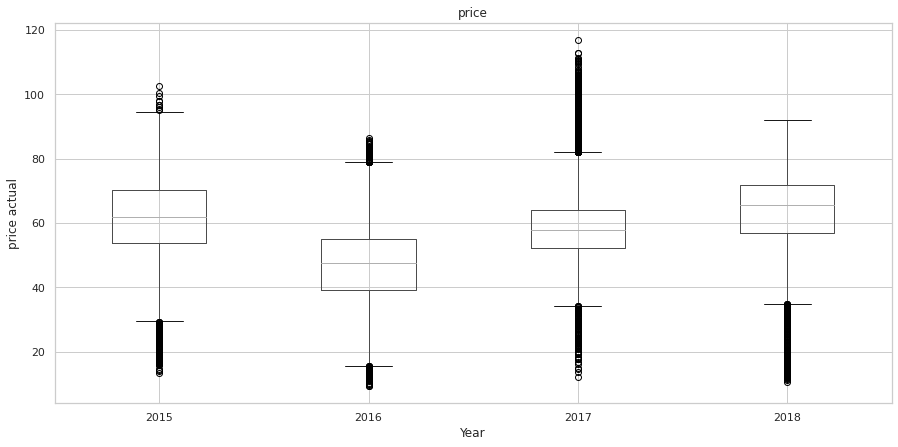

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(15,7))
df = pd.DataFrame()
groups = weathergy.set_index('time')['price actual'].groupby(pd.Grouper(freq='A'))

for name, group in groups:
    df[name.year] = pd.Series(group.values)

df.boxplot(ax=axs)
axs.set_xlabel('Year')
axs.set_ylabel('price actual')
axs.set_title('price')

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



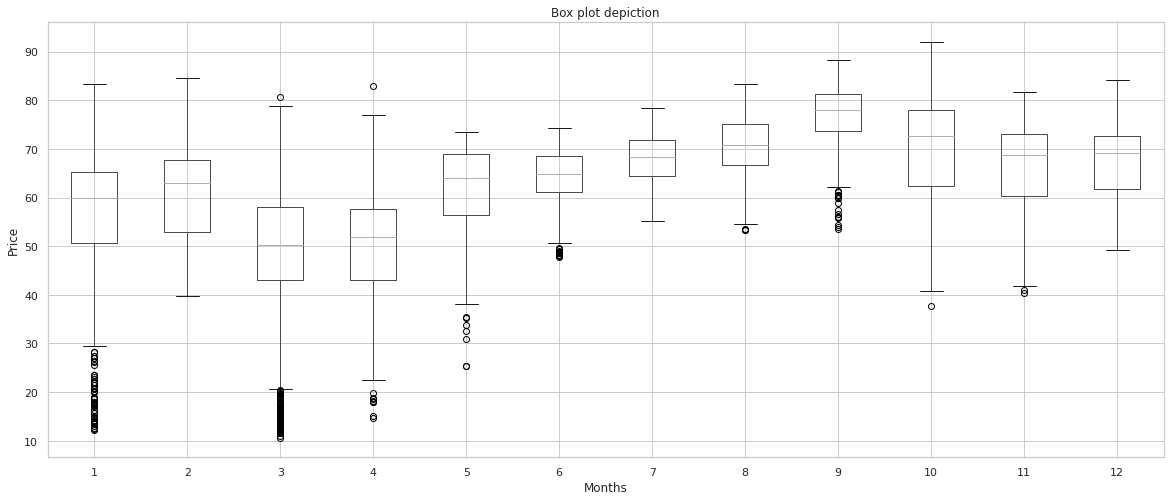

In [ ]:
groups = weathergy.set_index('time')['price actual'].groupby(pd.Grouper(freq = 'M', how = 'mean'))

df = pd.DataFrame()

for name, group in groups:
    df[name.month] = pd.Series(group.values)

plt.figure(figsize = (20, 8))

df.boxplot()

plt.xlabel('Months')
plt.ylabel('Price')
plt.title('Box plot depiction')

plt.show()

In [ ]:
G = []
for y in range(2015, 2019) :
  Q = []
  for m in range(1, 13) :
    if m < 10 :
      year_month = ('%d-0%d' % (y, m))
    else : year_month = ('%d-%d' % (y, m))

    val = weathergy.set_index('time')[year_month]['price actual'].mean()
    Q.append((year_month, val))
  G.append(Q)

Y = []
for i in G :
  elt = pd.DataFrame(data = i)
  Y.append(elt)
year_month_price = pd.concat(Y, axis = 0)

one_year_shift = year_month_price.shift(12).dropna()
one_year_shift[0] = year_month_price[0][12:]

fig = go.Figure(data = [
                      go.Scatter(x = year_month_price[0], y = year_month_price[1], mode = "markers + lines", name = 'Electricity price evolution'),
                      go.Scatter(x = one_year_shift[0], y = one_year_shift[1], mode = "markers + lines", name = 'Electricity price 1-year Lagged')
                      ])
fig.update_layout(height = 800, width = 1800, title_text = "Depicting electricity price evolution", xaxis_title = 'months', yaxis_title = 'Electricity Price')
fig.show()


The features containing 90 % or more of Zeros are : ['rain_1h_ Barcelona', 'rain_1h_Madrid', 'rain_1h_Seville', 'rain_1h_Valencia']


# Encoding categorical variables

In [ ]:
# Converting categorical feats to numerical ones using label encoding :
from sklearn.preprocessing import LabelEncoder

lab_enc = LabelEncoder()

for categ in categorical_feats :
  weathergy[categ] = lab_enc.fit_transform(weathergy[categ])

In [ ]:
weathergy

#Correlations with price and between variables

In [ ]:
correlations = weathergy.corr(method='pearson')

highly_correlated = correlations[correlations > 0.75]
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

generation fossil brown coal/lignite  generation fossil hard coal             0.768843
generation fossil hard coal           generation fossil brown coal/lignite    0.768843
temp_ Barcelona                       temp_Bilbao                             0.866727
                                      temp_Madrid                             0.903996
                                      temp_Seville                            0.841910
                                      temp_Valencia                           0.917506
temp_Bilbao                           temp_ Barcelona                         0.866727
                                      temp_Madrid                             0.872668
                                      temp_Seville                            0.821292
                                      temp_Valencia                           0.853744
temp_Madrid                           temp_ Barcelona                         0.903996
                                      temp_

In [ ]:
# Merging inter-correlated features :

## Merge 1 : Merging 'generation fossil brown coal/lignite' and 'generation fossil hard coal' by adding them together :
merge_1 = weathergy['generation fossil brown coal/lignite'] + weathergy['generation fossil hard coal']
weathergy.insert(2, 'generation fossil coal', merge_1)
weathergy = weathergy.drop(['generation fossil brown coal/lignite', 'generation fossil hard coal'], axis = 1)

### Merge 2 : Merging 'temp_ Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville' and 'temp_Valencia' by replacing their columns with a brand new one containing their mean :
merge_2 = (weathergy['temp_ Barcelona'] + weathergy['temp_Bilbao'] + weathergy['temp_Madrid'] + weathergy['temp_Seville'] + weathergy['temp_Valencia']) /5
weathergy.insert(17, 'temp_spain', merge_2)
weathergy = weathergy.drop(['temp_ Barcelona', 'temp_Bilbao', 'temp_Madrid', 'temp_Seville', 'temp_Valencia'], axis = 1)

#### Merge 3 : Merging 'pressure_Madrid' and 'pressure_Valencia' by replacing their columns with a brand new one containing their mean :
merge_3 = (weathergy['pressure_Madrid'] + weathergy['pressure_Valencia']) / 2
weathergy.insert(18, 'pressure_Madrid_Valencia', merge_3)
weathergy = weathergy.drop(['pressure_Madrid', 'pressure_Valencia'], axis = 1)

##### Merge 4 : Merging 'humidity_Madrid' and 'humidity_Seville' by replacing their columns with a brand new one containing their mean :
merge_4 = (weathergy['humidity_Madrid'] + weathergy['humidity_Seville']) / 2
weathergy.insert(19, 'humidity_Madrid_Seville', merge_4)
weathergy = weathergy.drop(['humidity_Madrid', 'humidity_Seville'], axis = 1)

In [ ]:
# Studying Correlation :
all_feats = weathergy.drop(['time', 'price actual'], axis = 1).columns

all_corr_coeffs = []
for feat in all_feats :
  all_corr_coeffs.append((feat, np.corrcoef(x = weathergy['price actual'], y = weathergy[feat])[0][1]))

CORR = pd.DataFrame(data = all_corr_coeffs)

# We will consider that a feat is important if it exceeds the mean of correlations :
mean_corr = sum([abs(coeff) for coeff in CORR[1].values]) / len(CORR)
threshold = 0.04

# Gathering feats with correlation lower & higher than threshold :
low_corr_feats = []
high_corr_feats = []

for (feat, corr) in all_corr_coeffs :
  if abs(corr) < threshold :
    low_corr_feats.append(feat)
  else : high_corr_feats.append(feat)

fig = go.Figure(data=[
                      go.Scatter(x = all_feats, y = CORR[1].values, mode = "markers + lines", name = "Correlation"),
                      go.Scatter(x = all_feats, y = [threshold for i in CORR[1].values], name = "mean correlation", line = dict(color = "#EF553B"), fill = 'tozeroy'),
                      go.Scatter(x = all_feats, y = [-threshold for i in CORR[1].values], name = "mean correlation (-)", line = dict(color = "#EF553B"), fill = 'tozeroy', showlegend = False)
                    ])
fig.update_layout(height = 800, width = 1800, title_text = "Depicting Correlation")
fig.show()

print('\n''There are', len(low_corr_feats), 'features with correlation coefficient LOWER than mean of all correlation coefficients are : ', low_corr_feats)
print('\n''There are', len(high_corr_feats), 'features with correlation coefficient HIGHER than mean of all correlation coefficients are : ', high_corr_feats)


There are 7 features with correlation coefficient LOWER than mean of all correlation coefficients are :  ['humidity_ Barcelona', 'clouds_all_ Barcelona', 'humidity_Bilbao', 'rain_1h_Madrid', 'rain_1h_Seville', 'rain_1h_Valencia', 'weather_description_Valencia']

There are 42 features with correlation coefficient HIGHER than mean of all correlation coefficients are :  ['generation biomass', 'generation fossil coal', 'generation fossil gas', 'generation fossil oil', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind onshore', 'total load actual', 'price day ahead', 'temp_spain', 'pressure_Madrid_Valencia', 'humidity_Madrid_Seville', 'pressure_ Barcelona', 'wind_speed_ Barcelona', 'wind_deg_ Barcelona', 'rain_1h_ Barcelona', 'weather_description_ Barcelona', 'pressure_Bilbao', 'wind_s

In [ ]:
# Removing feats with correlation coefficient lower than 0.04 :
weathergy = weathergy.drop(low_corr_feats, axis = 1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



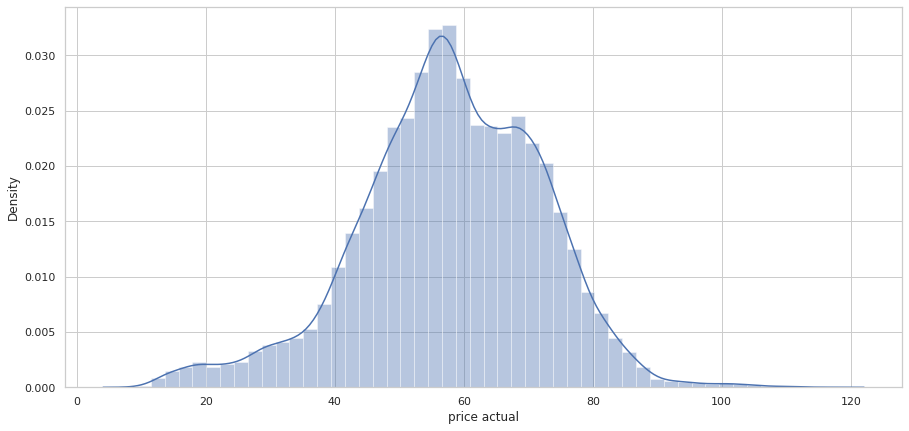

Skewness : -0.323749
Kurtosis : 0.469561


In [ ]:
# Visualize price distribution :
plt.figure(figsize = (15, 7))

sns.distplot(weathergy['price actual'])

plt.show()
print("Skewness : %f" % weathergy['price actual'].skew())
print("Kurtosis : %f" % weathergy['price actual'].kurt())

**Exploring Alternative : Sweetviz**

In [ ]:
#!pip install sweetviz

In [ ]:
'''# importing sweetviz
import sweetviz as sv

# analyzing the dataset
weathergy_report = sv.analyze(weathergy)

# display the report
weathergy_report.show_html('Weathergy_test.html')'''

"# importing sweetviz\nimport sweetviz as sv\n\n# analyzing the dataset\nweathergy_report = sv.analyze(weathergy)\n\n# display the report\nweathergy_report.show_html('Weathergy_test.html')"

In [ ]:
'''import sweetviz as sv

# Using Sweetviz to analyse corrolation between features and target :
weathergy_report = sv.analyze(weathergy, target_feat = 'price actual')

# display the report
weathergy_report.show_html('Weathergy_report.html')'''

"import sweetviz as sv\n\n# Using Sweetviz to analyse corrolation between features and target :\nweathergy_report = sv.analyze(weathergy, target_feat = 'price actual')\n\n# display the report\nweathergy_report.show_html('Weathergy_report.html')"

# **5. Feature Engineering**

In [ ]:
weathergy = weathergy.set_index(weathergy['time'])

# day / hour / month / date
weathergy['hour'] = weathergy['time'].dt.hour
weathergy['weekday'] = weathergy['time'].dt.dayofweek
weathergy['month'] = weathergy['time'].dt.month
# Some new features
# Generate 'business hour' feature
for i in range(len(weathergy)):
    position = weathergy.index[i]
    hour = position.hour
    if ((hour >= 8 and hour <= 14) or (hour >= 16 and hour <= 21)):
        weathergy.loc[position, 'business'] = 2
    elif (hour >= 14 and hour <= 16):
        weathergy.loc[position, 'business'] = 1
    else:
        weathergy.loc[position, 'business'] = 0
# Generate weekend features
# Generate 'weekend' feature
for i in range(len(weathergy)):
    position = weathergy.index[i]
    weekday = position.weekday()
    if (weekday == 6):
        weathergy.loc[position, 'weekend'] = 2
    elif (weekday == 5):
        weathergy.loc[position, 'weekend'] = 1
    else:
        weathergy.loc[position, 'weekend'] = 0
# Generate Holiday features

weathergy = weathergy.drop(['hour', 'weekday'], axis = 1)
weathergy.index = list(range(len(weathergy)))

In [ ]:
weathergy.head()

,time,generation biomass,generation fossil coal,generation fossil gas,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price day ahead,price actual,temp_spain,pressure_Madrid_Valencia,humidity_Madrid_Seville,pressure_ Barcelona,wind_speed_ Barcelona,wind_deg_ Barcelona,rain_1h_ Barcelona,weather_description_ Barcelona,pressure_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,wind_speed_Madrid,wind_deg_Madrid,clouds_all_Madrid,weather_description_Madrid,pressure_Seville,wind_speed_Seville,wind_deg_Seville,clouds_all_Seville,weather_description_Seville,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,clouds_all_Valencia,month,business,weekend
0,2015-01-01 00:00:00+00:00,447.0,5150.0,4844.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,73.0,49.0,196.0,6378.0,25385.0,50.10,65.41,272.491463,986.0,69.0,1035.0,7.0,58,0.0,23,1036.0,0.0,226,0.0,0,26,1.0,309,0,23,1039.0,1.0,21,0,24,77,1.0,62,0,1,0.0,0.0
1,2015-01-01 01:00:00+00:00,449.0,5083.0,5196.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,71.0,50.0,195.0,5890.0,24382.0,48.10,64.92,272.512700,986.0,69.0,1035.0,7.0,58,0.0,23,1035.0,0.0,229,0.0,0,26,1.0,309,0,23,1039.0,1.0,21,0,24,77,1.0,62,0,1,0.0,0.0
2,2015-01-01 02:00:00+00:00,448.0,4904.0,4857.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,73.0,50.0,196.0,5461.0,22734.0,47.33,64.48,272.099137,986.5,67.5,1036.0,7.0,48,0.0,23,1036.0,1.0,224,0.0,0,26,1.0,273,0,23,1039.0,3.0,27,0,24,78,0.0,23,0,1,0.0,0.0
3,2015-01-01 03:00:00+00:00,438.0,4385.0,4314.0,160.0,1503.0,949.0,779.0,7098.0,43.0,75.0,50.0,191.0,5238.0,21286.0,42.27,59.32,272.089469,986.5,67.5,1036.0,7.0,48,0.0,23,1035.0,1.0,225,0.0,0,26,1.0,273,0,23,1039.0,3.0,27,0,24,78,0.0,23,0,1,0.0,0.0
4,2015-01-01 04:00:00+00:00,428.0,4027.0,4130.0,156.0,1826.0,953.0,720.0,7097.0,43.0,74.0,42.0,189.0,4935.0,20264.0,38.41,56.04,272.145900,986.5,67.5,1036.0,7.0,48,0.0,23,1035.0,1.0,221,0.0,0,26,1.0,273,0,23,1039.0,3.0,27,0,24,78,0.0,23,0,1,0.0,0.0


**Stationarity test**

In [ ]:
from statsmodels.tsa.stattools import adfuller
X = weathergy['price actual'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -9.147016
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


# **6. MODELS**

In [ ]:
# This function enables us to add a row to a dataframe in a specific index.     We will use it through out our study
def Insert_row(row_number, df, row_value): 
  df1 = df.iloc[:row_number] 
  df2 = df.iloc[row_number:] 
  df1.loc[row_number] = row_value 
  df_result = pd.concat([df1, df2]) 
  df_result.index = [*range(df_result.shape[0])] 
  return df_result 

In [ ]:
# Importing all models :
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from lightgbm import LGBMRegressor

!pip install catboost
import catboost as CAT
from catboost import CatBoostRegressor

!pip install xgboost
import xgboost as Xgb
from xgboost import XGBRegressor

####

linregressor = LinearRegression()
rfr = RandomForestRegressor()
lightgbm = LGBMRegressor()
Cat = CatBoostRegressor()
xgb = XGBRegressor(objective = 'reg:squarederror')

In [ ]:
# Preparing our data :
weathergy_time = weathergy.drop('time', axis = 1)

# Splitting our data by taking the obs from '2015 - 2016 - 2017' as train set and '2018' as test set : 
X_train = weathergy_time.drop(['price actual'], axis = 1)[:26304]
Y_train = weathergy_time['price actual'][:26304]

X_test = weathergy_time.drop(['price actual'], axis = 1)[26304:]
Y_test = weathergy_time['price actual'][26304:]

In [ ]:
all_models = [('LinearRegression()', linregressor), ('RandomForestRegressor()', rfr), ('LGBMRegressor()', lightgbm), ('CatBoostRegressor()', Cat), ('XGBRegressor()', xgb)]

R = []

for (name, model) in all_models :
  model.fit(X = X_train, y = Y_train)

  model_predicted_train = model.predict(X_train)
  model_predicted_test = model.predict(X_test)

  model_RMSE_train = np.sqrt(MSE(y_true = Y_train , y_pred =  model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = Y_test , y_pred = model_predicted_test))

  R.append((name, round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

MODELS = pd.DataFrame(data = R, columns = ['Models', 'Train_RMSE', 'Test_RMSE'])

In [ ]:
MODELS

,Models,Train_RMSE,Test_RMSE
0,LinearRegression(),9.438,12.798
1,RandomForestRegressor(),1.455,14.136
2,LGBMRegressor(),4.164,13.368
3,CatBoostRegressor(),3.031,13.527
4,XGBRegressor(),6.338,13.062


In [ ]:
# Multiple Train-Test Splits :
from sklearn.model_selection import TimeSeriesSplit

splits = TimeSeriesSplit(n_splits = 10)

p = -1
data = pd.DataFrame()

for (train_index, test_index) in splits.split(weathergy_time) :
  R = []
  p += 1
  train = weathergy_time.iloc[train_index]
  test = weathergy_time.iloc[test_index]

  a_train = train.drop('price actual', axis = 1)
  b_train = train['price actual']

  a_test = test.drop('price actual', axis = 1)
  b_test = test['price actual']
  
  for (name, model) in all_models :
    model.fit(X = a_train, y = b_train)
    model_predicted_train = model.predict(a_train)
    model_predicted_test = model.predict(a_test)

    model_RMSE_train = np.sqrt(MSE(y_true = b_train , y_pred =  model_predicted_train))
    model_RMSE_test = np.sqrt(MSE(y_true = b_test , y_pred = model_predicted_test))

    R.append((round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

  dat = pd.DataFrame(data = R, columns = [('Train_RMSE split %d' % p), ('Test_RMSE split %d' % p)])
  data = pd.concat([data, dat], axis = 1)

MODELS_with_splits = pd.concat([MODELS, data], axis = 1)

In [ ]:
MODELS_with_splits

,Models,Train_RMSE,Test_RMSE,Train_RMSE split 0,Test_RMSE split 0,Train_RMSE split 1,Test_RMSE split 1,Train_RMSE split 2,Test_RMSE split 2,Train_RMSE split 3,Test_RMSE split 3,Train_RMSE split 4,Test_RMSE split 4,Train_RMSE split 5,Test_RMSE split 5,Train_RMSE split 6,Test_RMSE split 6,Train_RMSE split 7,Test_RMSE split 7,Train_RMSE split 8,Test_RMSE split 8,Train_RMSE split 9,Test_RMSE split 9
0,LinearRegression(),9.438,12.798,7.867,21.186,7.632,11.308,7.654,14.378,8.246,7.569,8.022,25.074,9.909,8.616,9.657,7.187,9.363,11.563,9.494,12.397,9.563,10.355
1,RandomForestRegressor(),1.455,14.136,1.758,10.679,1.593,11.257,1.601,14.706,1.486,9.657,1.403,22.506,1.511,7.700,1.471,6.072,1.429,13.583,1.511,12.438,1.529,11.228
2,LGBMRegressor(),4.164,13.368,2.255,12.134,2.826,11.874,3.332,14.664,3.614,7.939,3.629,22.147,3.967,6.908,4.025,5.369,4.057,12.779,4.414,12.216,4.650,10.746
3,CatBoostRegressor(),3.031,13.527,1.787,11.041,2.074,11.704,2.476,14.864,2.718,7.415,2.643,21.529,2.885,6.972,2.941,4.844,2.973,12.338,3.217,11.735,3.344,10.246
4,XGBRegressor(),6.338,13.062,5.070,11.709,5.128,12.085,5.532,14.478,5.784,7.726,5.770,22.463,6.421,6.595,6.390,5.607,6.285,12.099,6.738,12.174,6.899,11.407


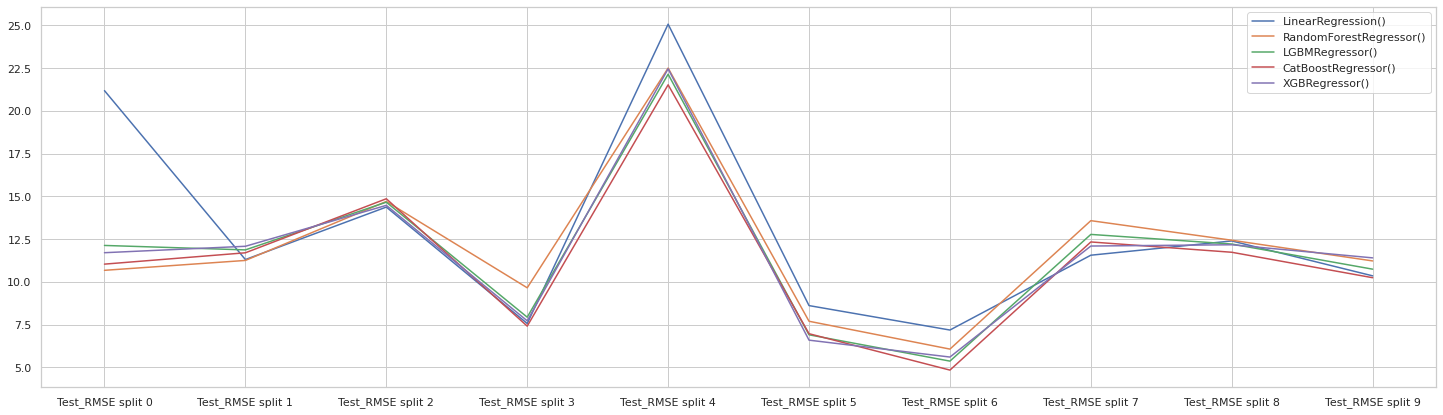


The optimal split is that of 'split 6'
OPT TRAIN INDEXES = [0, 22315]
OPT TEST INDEXES = [22316, 25502]


In [ ]:
test_rmse_splits = []
for i in range(1, len(data.columns), 2) :
  test_rmse_splits.append(data.columns[i])

plt.figure(figsize = (25, 7))

T = [(i, mod) for (i, mod) in zip(list(range(len(data))), list(MODELS.Models))]
for (i, mod) in T :
  plt.plot(data[test_rmse_splits].iloc[i], label = mod)
  plt.legend()

plt.show()

opt_split_train = list(list(splits.split(weathergy_time))[6][0])
opt_split_test = list(list(splits.split(weathergy_time))[6][1])

print('\n''The optimal split is that of \'split 6\'')
print(('OPT TRAIN INDEXES = [%d, %d]' % (min(opt_split_train), max(opt_split_train))))
print(('OPT TEST INDEXES = [%d, %d]' % (min(opt_split_test), max(opt_split_test))))

In [ ]:
# Let's now try to predict the price in the last 3187 hours of 2018 (that's approximately the last 4 months and a half of 2018) using the previous 22315 hours :
a = len(weathergy_time) - len(opt_split_train) - len(opt_split_test)
b = len(weathergy_time) - len(opt_split_test)

to_train = list(weathergy_time.index)[a : b]
to_test = list(weathergy_time.index)[b:]

M_train = weathergy_time.drop(['price actual'], axis = 1).iloc[to_train]
N_train = weathergy_time['price actual'][to_train]

M_test = weathergy_time.drop(['price actual'], axis = 1).iloc[to_test]
N_test = weathergy_time['price actual'][to_test]

R = []

for (name, model) in all_models :
  model.fit(X = M_train, y = N_train)

  model_predicted_train = model.predict(M_train)
  model_predicted_test = model.predict(M_test)

  model_RMSE_train = np.sqrt(MSE(y_true = N_train , y_pred =  model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = N_test , y_pred = model_predicted_test))

  R.append((name, round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

MODELS_last_4 = pd.DataFrame(data = R, columns = ['Models', 'Train_RMSE - train : 2 1/2 Y test 4 1/2 M', 'Test_RMSE - train : 2 1/2 Y test 4 1/2 M'])

In [ ]:
MODELS_last_4

,Models,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M
0,LinearRegression(),8.964,10.047
1,RandomForestRegressor(),1.323,11.274
2,LGBMRegressor(),3.866,10.682
3,CatBoostRegressor(),2.854,9.899
4,XGBRegressor(),6.222,11.102


In [ ]:
# Walk Forward Validation :
n_train = 5000
n_records = len(weathergy_time)
step = 1500

p = -1
data = pd.DataFrame()

for i in range(n_train, n_records, step) :
  R = []
  p += 1
  train, test = weathergy_time[0 : i], weathergy_time[ i : i + step]
	
  a_train = train.drop('price actual', axis = 1)
  b_train = train['price actual']

  a_test = test.drop('price actual', axis = 1)
  b_test = test['price actual']
  
  for (name, model) in all_models :
    model.fit(X = a_train, y = b_train)
    model_predicted_train = model.predict(a_train)
    model_predicted_test = model.predict(a_test)

    model_RMSE_train = np.sqrt(MSE(y_true = b_train , y_pred =  model_predicted_train))
    model_RMSE_test = np.sqrt(MSE(y_true = b_test , y_pred = model_predicted_test))

    R.append((round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

  dat = pd.DataFrame(data = R, columns = [('Train_RMSE expansion %d' % p), ('Test_RMSE expansion %d' % p)])
  data = pd.concat([data, dat], axis = 1)

MODELS_expansions = pd.concat([MODELS, data], axis = 1) 

In [ ]:
MODELS_expansions

,Models,Train_RMSE,Test_RMSE,Train_RMSE expansion 0,Test_RMSE expansion 0,Train_RMSE expansion 1,Test_RMSE expansion 1,Train_RMSE expansion 2,Test_RMSE expansion 2,Train_RMSE expansion 3,Test_RMSE expansion 3,Train_RMSE expansion 4,Test_RMSE expansion 4,Train_RMSE expansion 5,Test_RMSE expansion 5,Train_RMSE expansion 6,Test_RMSE expansion 6,Train_RMSE expansion 7,Test_RMSE expansion 7,Train_RMSE expansion 8,Test_RMSE expansion 8,Train_RMSE expansion 9,Test_RMSE expansion 9,Train_RMSE expansion 10,Test_RMSE expansion 10,Train_RMSE expansion 11,Test_RMSE expansion 11,Train_RMSE expansion 12,Test_RMSE expansion 12,Train_RMSE expansion 13,Test_RMSE expansion 13,Train_RMSE expansion 14,Test_RMSE expansion 14,Train_RMSE expansion 15,Test_RMSE expansion 15,Train_RMSE expansion 16,Test_RMSE expansion 16,Train_RMSE expansion 17,Test_RMSE expansion 17,Train_RMSE expansion 18,Test_RMSE expansion 18,Train_RMSE expansion 19,Test_RMSE expansion 19,Train_RMSE expansion 20,Test_RMSE expansion 20
0,LinearRegression(),9.438,12.798,7.937,6.668,7.607,6.509,7.335,13.795,7.639,13.542,8.014,11.186,8.244,7.309,8.106,7.684,8.042,14.174,8.321,29.774,9.964,9.504,9.894,7.556,9.739,7.281,9.582,6.676,9.425,10.506,9.447,9.980,9.456,10.742,9.495,10.645,9.497,12.211,9.567,12.544,9.669,7.168,9.571,6.512
1,RandomForestRegressor(),1.455,14.136,1.688,6.850,1.585,6.789,1.565,14.267,1.596,14.699,1.556,14.009,1.503,9.324,1.431,5.908,1.360,10.787,1.409,29.554,1.502,9.115,1.499,7.154,1.495,5.995,1.456,6.034,1.436,8.888,1.456,13.376,1.507,10.459,1.516,10.940,1.461,12.838,1.524,14.125,1.504,5.696,1.482,3.726
2,LGBMRegressor(),4.164,13.368,2.601,7.685,2.805,6.397,3.002,14.916,3.339,12.766,3.462,12.543,3.585,6.452,3.608,6.351,3.585,11.880,3.708,29.493,3.941,7.720,4.003,6.697,3.992,5.043,3.986,5.341,4.012,7.588,4.123,13.646,4.281,10.230,4.408,10.661,4.499,12.605,4.615,13.824,4.745,6.371,4.759,5.563
3,CatBoostRegressor(),3.031,13.527,1.991,7.576,2.097,6.090,2.257,15.080,2.465,13.187,2.638,13.873,2.695,6.764,2.688,6.760,2.640,12.021,2.696,26.956,2.841,7.172,2.907,7.323,2.928,4.681,2.909,4.674,2.923,6.868,3.038,14.067,3.116,9.949,3.235,10.672,3.268,12.391,3.388,12.254,3.445,7.823,3.464,5.281
4,XGBRegressor(),6.338,13.062,5.145,7.634,5.124,6.460,5.142,15.254,5.482,12.664,5.706,11.958,5.792,6.522,5.818,5.708,5.746,13.867,5.823,28.602,6.445,7.518,6.471,6.635,6.459,4.660,6.373,5.565,6.231,8.394,6.327,11.956,6.566,9.971,6.737,10.488,6.831,12.635,6.882,14.311,7.164,5.973,7.093,4.660


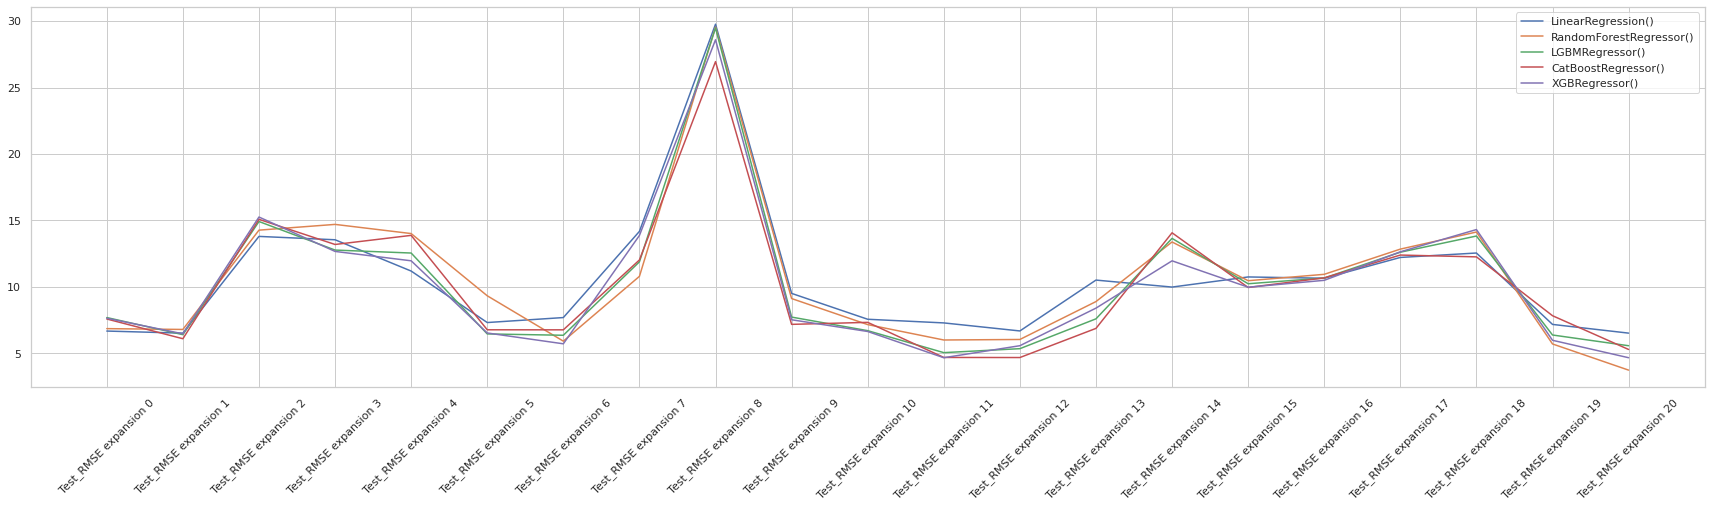


The optimal expansion is that of 'expansion 11'
OPT TRAIN INDEXES = [0, 21499]
OPT Test INDEXES = [21500, 22999]


In [ ]:
test_rmse_expansions = []
for i in range(1, len(data.columns), 2) :
  test_rmse_expansions.append(data.columns[i])

plt.figure(figsize = (30, 7))

T = [(i, mod) for (i, mod) in zip(list(range(len(data))), list(MODELS.Models))]
for (i, mod) in T :
  plt.plot(data[test_rmse_expansions].iloc[i], label = mod)
  plt.legend()
plt.xticks(rotation = 45)
plt.show()

train_exp = []
test_exp = []
for i in range(n_train, n_records, step) :
  train_exp.append(list(weathergy_time[0 : i].index))
  test_exp.append(list(weathergy_time[ i : i + step].index))

print('\n''The optimal expansion is that of \'expansion 11\'')
print(('OPT TRAIN INDEXES = [%d, %d]' % (min(train_exp[11]), max(train_exp[11]))))
print(('OPT Test INDEXES = [%d, %d]' % (min(test_exp[11]), max(test_exp[11]))))

In [ ]:
# Let's now try to predict the price in the last 1500 hours of 2018 (that's approximately the last 2 months of 2018) using the previous 21500 hours :
a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]
to_test = list(weathergy_time.index)[b:]

X_train = weathergy_time.drop(['price actual'], axis = 1).iloc[to_train]
Y_train = weathergy_time['price actual'][to_train]

X_test = weathergy_time.drop(['price actual'], axis = 1).iloc[to_test]
Y_test = weathergy_time['price actual'][to_test]

R = []

for (name, model) in all_models :
  model.fit(X = X_train, y = Y_train)

  model_predicted_train = model.predict(X_train)
  model_predicted_test = model.predict(X_test)

  model_RMSE_train = np.sqrt(MSE(y_true = Y_train , y_pred =  model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = Y_test , y_pred = model_predicted_test))

  R.append((name, round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

MODELS_last_2 = pd.DataFrame(data = R, columns = ['Models', 'Train_RMSE - train : 2 1/2 Y test 2 M', 'Test_RMSE - train : 2 1/2 Y test 2 M'])

In [ ]:
MODELS_last_2

,Models,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M
0,LinearRegression(),8.619,5.991
1,RandomForestRegressor(),1.308,6.647
2,LGBMRegressor(),3.821,6.457
3,CatBoostRegressor(),2.826,7.680
4,XGBRegressor(),6.265,5.541


In [ ]:
# Recap 1 :
MODELS = pd.concat([MODELS, MODELS_last_4.drop('Models', axis = 1), MODELS_last_2.drop('Models', axis = 1)], axis = 1)
MODELS

,Models,Train_RMSE,Test_RMSE,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M
0,LinearRegression(),9.438,12.798,8.964,10.047,8.619,5.991
1,RandomForestRegressor(),1.455,14.136,1.323,11.274,1.308,6.647
2,LGBMRegressor(),4.164,13.368,3.866,10.682,3.821,6.457
3,CatBoostRegressor(),3.031,13.527,2.854,9.899,2.826,7.680
4,XGBRegressor(),6.338,13.062,6.222,11.102,6.265,5.541


**Conclusion : In the rest of our study we will use the train and test sets obtained during Walk Forward cross validation**

**Identifying outliers :**

In [ ]:
# Using Isolation Forest : (Isolation Forest is a methode that thrives on subsets of the original data because it makes the task of finding the anomalies easier for the algorithm)
from sklearn.ensemble import IsolationForest

a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]

# Let's split the TRAIN SET into mutiple subsets :
DATA = weathergy.drop(['time', 'price actual'], axis = 1).iloc[to_train]

INDEXES = list(DATA.index)

step = 720  # Monthly divide
increment = len(INDEXES) // step

time_jumps = []
for i in range(increment) :
  if i == 0 :
    split = INDEXES[i + i*step : (1+i)*step]
  else : split = INDEXES[i + i*step - 1: i + (1+i)*step]
  time_jumps.append(split)

time_jumps[-1] += list(range(time_jumps[-1][-1] , list(DATA.index)[-1]))

splits = []
for span in time_jumps :
  splits.append(DATA.loc[span])

# Anomaly detection using Isolation Forest on the sub sets :

iso = IsolationForest(n_estimators = 500, contamination = 0.01, random_state = 42, n_jobs = -1)

k = 0
k_index_split_outliers = []
for chunk in splits :
  k += 1
  not_inliers = iso.fit_predict(chunk)
  k_index_split_outliers.append((k, chunk.index, chunk, not_inliers))

In [ ]:
# Visualize ouliers in a random chunk :
import random

chunk = random.choice(k_index_split_outliers)

plt.figure(figsize = (30, 300))

v = 0
for feat in weathergy_time.drop('price actual', axis = 1).columns :
  v += 1
  plt.subplot(23, 2, v)
  sns.scatterplot(x = chunk[2][feat], y = weathergy['price actual'][chunk[1]], hue = chunk[3], palette = ['red','b'], legend = False)

In [ ]:
# Extracting the number of outliers :
D = []
for _,ind,_,out in k_index_split_outliers :
  B = [(i, o) for (i, o) in zip(ind, out)]
  liers = []
  for (i, o) in B :
    if o == -1 :
      liers.append(i)
  D.append(liers)

ALL_OUTLIERS = []
for elt in D :
  for i in elt :
    ALL_OUTLIERS.append(i)

In [ ]:
weathergy.iloc[ALL_OUTLIERS]

,time,generation biomass,generation fossil coal,generation fossil gas,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,total load actual,price actual,temp_spain,pressure_ Barcelona,pressure_Madrid_Valencia,humidity_Madrid_Seville,wind_speed_ Barcelona,wind_deg_ Barcelona,rain_1h_ Barcelona,weather_description_ Barcelona,pressure_Bilbao,wind_speed_Bilbao,wind_deg_Bilbao,rain_1h_Bilbao,clouds_all_Bilbao,weather_description_Bilbao,wind_speed_Madrid,wind_deg_Madrid,clouds_all_Madrid,weather_description_Madrid,pressure_Seville,wind_speed_Seville,wind_deg_Seville,clouds_all_Seville,weather_description_Seville,humidity_Valencia,wind_speed_Valencia,wind_deg_Valencia,clouds_all_Valencia,month,business,weekend
12184,2016-05-22 16:00:00+00:00,282.0,651.0,2884.0,214.0,905.0,1529.0,3189.0,5080.0,11.0,61.0,3923.0,198.0,9853.0,22934.0,15.16,295.7960,1012.0,1014.0,32.5,7.0,220,3.0,5,1020.0,11.0,320,0.0,40,24,9.0,290,20,2,1019.0,2.0,350,20,3,20,10.0,270,20,5,2.0,2.0
12348,2016-05-29 12:00:00+00:00,274.0,693.0,3052.0,198.0,3303.0,1563.0,2104.0,6062.0,13.0,65.0,3618.0,251.0,9285.0,25035.0,21.97,294.5240,1011.0,1016.5,54.0,5.0,310,0.0,2,1015.0,3.0,330,0.9,75,16,4.0,0,75,0,1021.0,2.0,250,20,3,29,10.0,270,20,5,2.0,2.0
12351,2016-05-29 15:00:00+00:00,285.0,666.0,2907.0,189.0,3319.0,1514.0,1521.0,6058.0,12.0,61.0,3412.0,247.0,8730.0,22940.0,15.11,295.5660,1011.0,1015.5,59.0,9.0,220,0.0,21,1015.0,4.0,320,0.3,75,11,1.0,0,75,0,1020.0,4.0,270,40,22,22,9.0,270,20,5,1.0,2.0
12638,2016-06-10 14:00:00+00:00,318.0,6238.0,7893.0,302.0,0.0,427.0,1220.0,6997.0,50.0,88.0,4416.0,291.0,3130.0,30812.0,43.90,300.3548,995.0,996.5,30.5,2.0,104,12.0,30,998.0,1.0,270,0.3,92,11,4.0,294,0,23,1021.0,3.0,290,12,3,33,0.0,270,8,6,2.0,0.0
12650,2016-06-11 02:00:00+00:00,331.0,2908.0,3839.0,206.0,3314.0,642.0,362.0,6038.0,56.0,76.0,24.0,288.0,7546.0,20004.0,45.56,292.7560,996.0,1013.5,48.5,5.0,62,12.0,30,999.0,0.0,315,0.0,80,0,1.0,347,44,21,1020.0,2.0,257,92,16,88,1.0,87,20,6,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33543,2018-10-29 15:00:00+00:00,307.0,3314.0,6336.0,324.0,323.0,689.0,869.0,6047.0,67.0,92.0,3289.0,300.0,13505.0,32558.0,62.13,285.3780,991.0,1001.0,37.5,5.0,280,0.0,23,1002.0,9.0,330,0.0,75,20,7.0,280,40,21,1009.0,6.0,250,20,3,31,8.0,300,20,10,1.0,0.0
33544,2018-10-29 16:00:00+00:00,306.0,3433.0,6397.0,320.0,207.0,697.0,880.0,6047.0,67.0,92.0,2596.0,286.0,13232.0,32271.0,63.66,285.6260,991.0,1001.5,32.0,5.0,250,0.0,23,1002.0,6.0,330,0.0,20,2,7.0,280,40,21,1009.0,7.0,280,20,3,30,11.0,300,20,10,2.0,0.0
33545,2018-10-29 17:00:00+00:00,306.0,3688.0,7658.0,321.0,60.0,694.0,1594.0,6048.0,67.0,90.0,1249.0,292.0,12288.0,32282.0,72.66,285.9200,990.0,1001.5,30.5,5.0,250,0.0,23,1002.0,4.0,320,0.0,40,24,5.0,280,75,0,1009.0,7.0,280,20,3,30,10.0,290,20,10,2.0,0.0
33546,2018-10-29 18:00:00+00:00,304.0,3908.0,8144.0,325.0,1.0,714.0,3419.0,6049.0,68.0,88.0,435.0,299.0,11344.0,33872.0,76.48,285.0980,990.0,1002.0,46.0,7.0,240,0.0,23,1002.0,5.0,300,0.0,20,2,5.0,260,75,0,1009.0,8.0,290,20,3,33,7.0,280,20,10,2.0,0.0


In [ ]:
# Let's remove the outliers and fit our model to the refined data :
a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]

train_data = weathergy_time.iloc[to_train]
train_without_outliers = train_data.drop(ALL_OUTLIERS, axis = 0)

X_train_no_out = train_without_outliers.drop(['price actual'], axis = 1)
Y_train_no_out = train_without_outliers['price actual']

X_test_no_out = weathergy_time.drop(['price actual'], axis = 1)[b:]
Y_test_no_out = weathergy_time['price actual'][b:]

R = []

for (name, model) in all_models :
  model.fit(X = X_train_no_out, y = Y_train_no_out)

  model_predicted_train = model.predict(X_train_no_out)
  model_predicted_test = model.predict(X_test_no_out)

  model_RMSE_train = np.sqrt(MSE(y_true = Y_train_no_out , y_pred =  model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = Y_test_no_out , y_pred = model_predicted_test))

  R.append((name, round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

MODELS_iForest = pd.DataFrame(data = R, columns = ['Models', 'Train_RMSE iforest', 'Test_RMSE iforest'])

In [ ]:
MODELS_iForest

,Models,Train_RMSE iforest,Test_RMSE iforest
0,LinearRegression(),8.553,6.029
1,RandomForestRegressor(),1.300,6.541
2,LGBMRegressor(),3.787,6.632
3,CatBoostRegressor(),2.791,7.528
4,XGBRegressor(),6.251,5.576


In [ ]:
# Extracting outliers using z-score :
# i. Determine the maximum value of z-score in out data :
a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]

weathergy_time_price_2M = weathergy.drop(['time', 'price actual'], axis = 1).loc[a:]

numz = weathergy_time_price_2M.dtypes.index
z = np.abs(stats.zscore(weathergy_time_price_2M[numz]))

C = []
for line in z :
  C.append(max(line))

print('The maximum value of z-score in weathergy_time_price_2M is : ', round(max(C), 3))

The maximum value of z-score in weathergy_time_price_2M is :  23.653


In [ ]:
# ii. Determine the position and the number of outliers (z-score > 3) in weathergy_time_price :
threshold = 3

D = []
for i in np.where(z > threshold):
  D.append(list(i))
Pos_num = pd.DataFrame({'row_index' : D[0], 'column_index' : D[1]})
new_ind = [(i + to_train[0]) for i in list(Pos_num.index)]
Pos_num.index = new_ind
Pos_num

,row_index,column_index
12064,4,6
12065,5,33
12066,14,6
12067,15,6
12068,15,11
...,...,...
19489,22884,35
19490,22885,35
19491,22898,2
19492,22899,2


In [ ]:
coords = [(a, b) for (a, b) in zip(Pos_num.row_index, Pos_num.column_index)]

COORDS = []
for l in set(Pos_num.column_index) :
  F = []
  for (i, j) in coords :
    if j == l :
      F.append(i)
  COORDS.append((l, F))

irregularities = []
for (a, b) in COORDS :
  data_out = pd.DataFrame(data = weathergy_time_price_2M[list(weathergy_time_price_2M.columns)[a]].iloc[b])
  irregularities.append(data_out)


IRREGULARITIES = pd.concat(irregularities, axis = 1)

for elt in irregularities :
  display(elt)

,generation biomass
12431,531.0
12432,526.0
12433,524.0
12434,514.0
12435,496.0
...,...
32942,195.0
32943,196.0
32944,197.0
32945,200.0


,generation fossil gas
16448,13187.0
16449,14436.0
16450,14631.0
16451,14184.0
16452,14030.0
...,...
34050,13233.0
34052,13250.0
34962,13155.0
34963,13292.0


,generation fossil oil
13135,416.0
13136,428.0
13137,415.0
13138,429.0
13139,439.0
...,...
29154,118.0
29155,142.0
29315,44.0
29489,141.0


,generation hydro pumped storage consumption
12171,2770.0
12172,2881.0
12173,2924.0
12174,2856.0
12175,2724.0
...,...
34432,3257.0
34433,3161.0
34434,3547.0
34435,3516.0


,generation hydro water reservoir
12068,8056.0
12078,7795.0
12079,9066.0
12080,8847.0
12081,8480.0
...,...
34409,7724.0
34410,7525.0
34412,8311.0
34413,9728.0


,generation nuclear
25125,0.0
25164,0.0
25171,0.0
29315,998.0


,generation other
13903,102.0
13904,102.0
15368,100.0
15370,100.0
15375,100.0
15376,100.0
15377,100.0
15379,100.0
16118,100.0
17649,5.0


,generation other renewable
12169,61.0
12170,62.0
12171,61.0
12172,60.0
12173,59.0
...,...
16806,61.0
25125,0.0
25164,0.0
25171,0.0


,generation waste
12079,183.0
12080,181.0
12081,187.0
12082,181.0
12083,186.0
...,...
34435,157.0
34436,160.0
34437,162.0
34438,163.0


,generation wind onshore
12420,15203.0
12421,15127.0
13164,15347.0
13165,15576.0
13166,15426.0
...,...
28287,15247.0
28288,15160.0
28289,15130.0
33669,14963.0


,pressure_ Barcelona
12615,996.0
12616,996.0
12618,995.0
12619,995.0
12620,995.0
...,...
33546,990.0
33547,991.0
33548,992.0
33549,994.0


,pressure_Madrid_Valencia
13444,978.0
13445,978.0
13446,978.5
13447,978.5
13448,978.5
...,...
34018,980.0
34215,971.5
34216,971.5
34217,971.5


,wind_speed_ Barcelona
12087,9.0
12088,9.0
12089,9.0
12090,10.0
12211,10.0
...,...
34045,9.0
34046,9.0
34375,9.0
34706,9.0


,rain_1h_ Barcelona
12093,3.0
12094,3.0
12096,3.0
12184,3.0
12186,3.0
...,...
33592,3.0
33601,3.0
33798,3.0
33938,3.0


,pressure_Bilbao
12754,985.0
12755,985.0
12756,985.0
12757,984.0
12758,985.0
...,...
34045,977.0
34046,977.0
34047,975.0
34048,975.0


,wind_speed_Bilbao
12181,8.0
12182,9.0
12183,11.0
12184,11.0
12185,10.0
...,...
34738,9.0
34740,10.0
34741,8.0
34742,9.0


,rain_1h_Bilbao
12104,3.0
12168,0.9
12176,0.9
12179,0.9
12235,3.0
...,...
34620,0.9
34630,0.9
34632,0.9
34683,0.9


,wind_speed_Madrid
12175,8.0
12176,9.0
12177,8.0
12183,8.0
12184,9.0
...,...
34623,10.0
34627,8.0
34696,8.0
34697,8.0


,pressure_Seville
13058,995.0
13178,993.0
13421,998.0
13439,995.0
13729,997.0
...,...
27827,998.0
27828,998.0
27829,997.0
27830,998.0


,wind_speed_Seville
12069,8.0
12329,9.0
12330,10.0
12472,8.0
12473,8.0
...,...
34617,10.0
34621,8.0
34622,9.0
34624,9.0


,clouds_all_Seville
12174,90
12648,92
12649,92
12650,92
13015,90
...,...
34712,90
34755,92
34947,88
34948,88


,wind_speed_Valencia
12184,10.0
12185,10.0
12331,10.0
12332,13.0
12346,10.0
...,...
34210,11.0
34211,10.0
34212,12.0
34635,10.0


,clouds_all_Valencia
12764,92
14095,92
14096,92
14097,92
14098,92
...,...
34041,92
34042,92
34045,92
34046,92


In [ ]:
# iii. Determine the optimal number of outliers to remove in order to minmize RMSE of each model :
a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]

weathergy_time_2M = weathergy.drop('time', axis = 1).loc[a:]
E = []

for (name, model) in all_models :
  list_ks = []
  # Range of z-score
  for k in range(3, 11) :
    l = []
    for i in np.where(z > k) :
      l.append(list(i))

    changed_ind = []
    for j in l[0] :
      q = j + to_train[0]
      changed_ind.append(q)

    L = pd.DataFrame({'row_index' : changed_ind, 'column_index' : l[1]})
  
    # k (z-score threshold)
    weathergy_without_outliers = weathergy_time_2M[(z < k).all(axis = 1)]

    # Splitting our data : 
    X_train_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[:b]
    Y_train_refined = weathergy_without_outliers['price actual'].loc[:b]

    X_test_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[b:]
    Y_test_refined = weathergy_without_outliers['price actual'].loc[b:]

    # Using Label Encoding :
    model.fit(X = X_train_refined, y = Y_train_refined)

    model_predicted_train = model.predict(X_train_refined)
    model_predicted_test = model.predict(X_test_refined)

    model_RMSE_train = np.sqrt(MSE(y_true = Y_train_refined, y_pred = model_predicted_train))
    model_RMSE_test = np.sqrt(MSE(y_true = Y_test_refined, y_pred = model_predicted_test))

    list_ks.append((model_RMSE_test, model_RMSE_train, k))
    list_ks.sort()

  E.append((name, list_ks[0][2], round(list_ks[0][1], 3), round(list_ks[0][0], 3)))

WITHOUT_OUTLIERS = pd.DataFrame(data = E, columns = ['Models', 'Threshold', 'Train_RMSE z-score', 'Test_RMSE z-score'])

In [ ]:
WITHOUT_OUTLIERS

,Models,Threshold,Train_RMSE z-score,Test_RMSE z-score
0,LinearRegression(),5,8.597,5.975
1,RandomForestRegressor(),3,1.290,6.309
2,LGBMRegressor(),7,3.795,6.415
3,CatBoostRegressor(),6,2.813,7.443
4,XGBRegressor(),5,6.189,5.518


In [ ]:
# Recap 2 :
MODELS = pd.concat([MODELS, MODELS_iForest.drop('Models', axis = 1), WITHOUT_OUTLIERS.drop(['Models', 'Threshold'], axis = 1)], axis = 1)
MODELS

,Models,Train_RMSE,Test_RMSE,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M,Train_RMSE iforest,Test_RMSE iforest,Train_RMSE z-score,Test_RMSE z-score
0,LinearRegression(),9.438,12.798,8.964,10.047,8.619,5.991,8.553,6.029,8.597,5.975
1,RandomForestRegressor(),1.455,14.136,1.323,11.274,1.308,6.647,1.300,6.541,1.290,6.309
2,LGBMRegressor(),4.164,13.368,3.866,10.682,3.821,6.457,3.787,6.632,3.795,6.415
3,CatBoostRegressor(),3.031,13.527,2.854,9.899,2.826,7.680,2.791,7.528,2.813,7.443
4,XGBRegressor(),6.338,13.062,6.222,11.102,6.265,5.541,6.251,5.576,6.189,5.518


As we can see the z-score method of removing outliers in our case is better than Isolation Forest 

In [ ]:
# Using pmdarima
!pip install pmdarima

import pmdarima as pm
from pmdarima.model_selection import train_test_split

In [ ]:
arima = pm.auto_arima(X = X_train, y = Y_train)

pred_train = model.predict(X_train)
forecasts = model.predict(X_test)

arima_RMSE_train = np.sqrt(MSE(y_true = Y_train , y_pred =  pred_train))
arima_RMSE_test = np.sqrt(MSE(y_true = Y_test , y_pred =  forecasts))

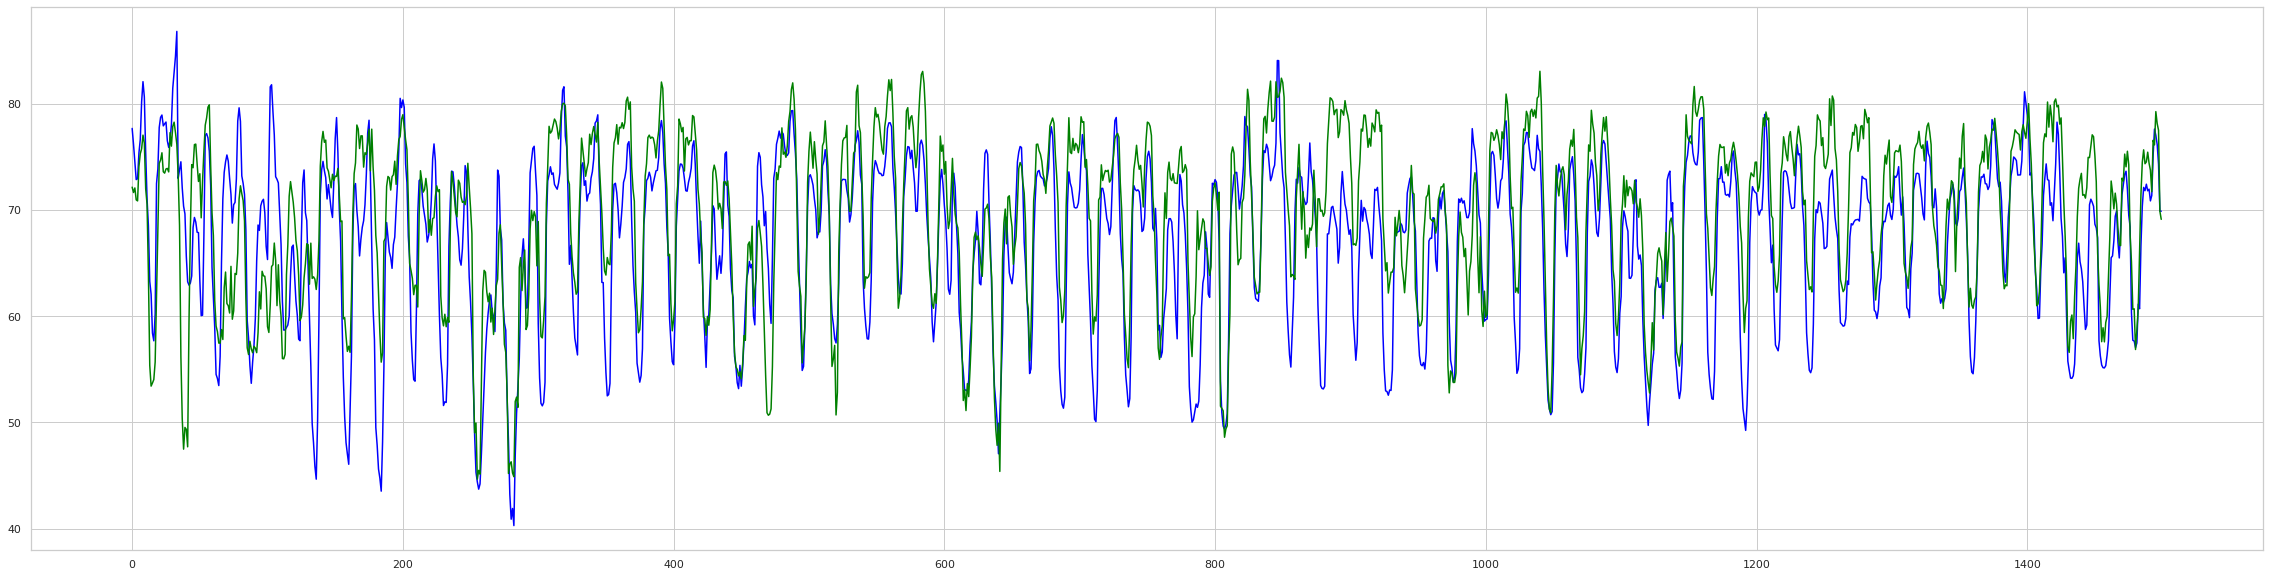


RMSE of train set is : 6.298
RMSE of test set is : 5.655


In [ ]:
# Visualize the forecasts (blue=train, green=forecasts)
plt.figure(figsize = (40, 10))

plt.plot(Y_test.values, 'blue')
plt.plot(forecasts, 'green')

plt.show()

print('\n''RMSE of train set is :', round(arima_RMSE_train, 3))
print('RMSE of test set is :', round(arima_RMSE_test, 3))

In [ ]:
# Recap 3 :
L_0 = ['pm.auto_arima()', round(arima_RMSE_train, 3), round(arima_RMSE_test, 3), '', '', '', '', '', '', '', '']

MODELS = Insert_row(5, MODELS, L_0)

In [ ]:
MODELS

,Models,Train_RMSE,Test_RMSE,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M,Train_RMSE iforest,Test_RMSE iforest,Train_RMSE z-score,Test_RMSE z-score
0,LinearRegression(),9.438,12.798,8.964,10.047,8.619,5.991,8.553,6.029,8.597,5.975
1,RandomForestRegressor(),1.455,14.136,1.323,11.274,1.308,6.647,1.3,6.541,1.29,6.309
2,LGBMRegressor(),4.164,13.368,3.866,10.682,3.821,6.457,3.787,6.632,3.795,6.415
3,CatBoostRegressor(),3.031,13.527,2.854,9.899,2.826,7.68,2.791,7.528,2.813,7.443
4,XGBRegressor(),6.338,13.062,6.222,11.102,6.265,5.541,6.251,5.576,6.189,5.518
5,pm.auto_arima(),6.298,5.655,,,,,,,,


# **7. Hyperparameters tuning using Bayesian Optimization :**

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

**1. Bayesian Optimization applied to LGBMRegressor (14 Parameters are selected) :**

In [ ]:
def LGBM_Bayes_Tuning(X, Y, init_round, opt_round, n_folds, random_seed, n_estimators) :
    # Prepare the features dataset :
    train_data = lgb.Dataset(data = X, label = Y, free_raw_data = False)
    
    # Parameters selected for tuning (14 Parameters are selected) :
    def eval(num_leaves, feature_fraction, max_depth, min_split_gain, min_child_weight, min_child_samples, reg_alpha, reg_lambda, learning_rate, subsample, colsample_bytree, min_data_in_leaf, lambda_l1, lambda_l2):
        params = {
            "objective" : 'regression',
            "bagging_fraction" : 0.8,
            "bagging_freq": 1,
            "verbosity": -1,
            "metric" : 'rmse'
        }
        params['num_leaves'] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        params['min_child_samples'] = min_child_samples
        params['reg_alpha'] = reg_alpha
        params['reg_lambda'] = reg_lambda
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['min_data_in_leaf'] = int(round(min_data_in_leaf)) 
        params['lambda_l1'] = lambda_l1
        params['lambda_l2'] = lambda_l2
 
        cv_result = lgb.cv(params, train_data, nfold = n_folds, seed = random_seed, verbose_eval = 200,stratified=False)

        return (-1.0 * np.array(cv_result['rmse-mean'])).max()

    # Tuning the 14 parameters selected using BayesianOptimization :
    Opt = BayesianOptimization(f = eval, pbounds = {'feature_fraction': (0.1, 1.0),   # Set ranges upon which the tuning will take place
                                                    'max_depth': (1, 50),
                                                    'num_leaves' : (50,500),
                                                    'min_split_gain': (0.001, 0.5),
                                                    'min_child_weight': (3, 100),
                                                    'min_child_samples' : (1, 50),
                                                    'reg_alpha' : (1, 10),
                                                    'reg_lambda' : (1, 10),
                                                    'learning_rate' : (0.001, 0.5),
                                                    'subsample' : (0.1, 1.0),
                                                    'colsample_bytree' : (0.1, 1.0),
                                                    'min_data_in_leaf' : (1, 100),
                                                    'lambda_l1': (0.1, 10),
                                                    'lambda_l2': (0.1, 10)
                                                    }, random_state = 42)
    Opt.maximize(init_points = init_round, n_iter = opt_round, acq = 'ei')

        # Return best parameters :
    BEST = pd.DataFrame(Opt.res)
    best_params = list(BEST[BEST.target == max(BEST.target)].params)[0]    
    return best_params

In [ ]:
# Hyperparameters tuning using Bayesian Optimization : 
LGBM_best_params = LGBM_Bayes_Tuning(X = X_train, Y = Y_train, init_round = 20, opt_round = 20, n_folds = 10, random_seed = 42, n_estimators = 7000)

|   iter    |  target   | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -4.334    |  0.4371   |  0.9556   |  7.347    |  6.027    |  0.07885  |  8.644    |  3.846    |  87.02    |  60.51    |  0.3543   |  59.26    |  9.729    |  8.492    |  0.2911   |
|  2        | -3.947    |  0.2636   |  0.2651   |  3.112    |  5.295    |  0.2165   |  15.27    |  30.98    |  16.53    |  29.92    |  0.1838   |  255.2    |  8.067    |  2.797    |  0.5628   |
|  3        | -7.083    |  0.6332   |  0.1418   |  6.115    |  1.788    |  0.03346  |  47.5     |  48.32    |  81.41    |  31.16    |  0.04974  |  357.9    |  4.961    |  2.098    |  0.5457   |
|  4        | -3.545    |  0.1

In [ ]:
# Best Parameters of LGBMRegressor :
LGBM_best_params

{'colsample_bytree': 0.8826251881706276,
 'feature_fraction': 0.9993473383012929,
 'lambda_l1': 3.3906808650076914,
 'lambda_l2': 7.141816021177675,
 'learning_rate': 0.19228001074573395,
 'max_depth': 12.702510318714324,
 'min_child_samples': 36.17363226157706,
 'min_child_weight': 37.854444970521875,
 'min_data_in_leaf': 25.992039093825046,
 'min_split_gain': 0.30010198951756967,
 'num_leaves': 120.22042216279824,
 'reg_alpha': 6.894364111158153,
 'reg_lambda': 5.970701521997151,
 'subsample': 0.1385307620912042}

**2. Bayesian Optimization applied to CatBoostRegressor (2 Parameters are selected) :**

In [ ]:
def CAT_Bayes_Tuning(X, Y, init_round, opt_round, n_folds, random_seed, n_estimators):
    # Prepare the features dataset :
    train_data = CAT.Pool(data = X, label = Y)

    # Parameters selected for tuning (2 Parameters are selected) :
    def eval(depth, bagging_temperature):
        params = {
            "iterations": 100,
            "learning_rate": 0.05,
            "eval_metric": "R2",
            "verbose": False,
            "loss_function" : 'RMSE',
        }
        params[ "depth"] = int(round(depth)) 
        params["bagging_temperature"] = bagging_temperature
 
        cv_result = CAT.cv(train_data, params, nfold = n_folds, seed = random_seed, verbose_eval = 200, stratified = False)

        return np.max(cv_result['test-R2-mean'])

    # Tuning the 2 parameters selected using BayesianOptimization :
    Opt = BayesianOptimization(f = eval, pbounds = {'depth': (1, 12),           # Set ranges upon which the tuning will take place
                                                    'bagging_temperature': (1, 30)
                                                    }, random_state = 42)
    Opt.maximize(init_points = init_round, n_iter = opt_round, acq = 'ei')

        # Return best parameters :
    BEST = pd.DataFrame(Opt.res)
    best_params = list(BEST[BEST.target == max(BEST.target)].params)[0]    
    return best_params

In [ ]:
CAT_best_params = CAT_Bayes_Tuning(X_train, Y_train, init_round = 5, opt_round = 5, n_folds = 10, random_seed = 42, n_estimators = 7000)

|   iter    |  target   | baggin... |   depth   |
-------------------------------------------------
0:	learn: -19.3414683	test: -19.3795968	best: -19.3795968 (0)	total: 1.95s	remaining: 3m 13s
99:	learn: 0.8629469	test: 0.8207758	best: 0.8207758 (99)	total: 3m 3s	remaining: 0us
|  1        |  0.8208   |  11.86    |  11.46    |
0:	learn: -19.3085199	test: -19.3428281	best: -19.3428281 (0)	total: 603ms	remaining: 59.7s
99:	learn: 0.7848204	test: 0.7649593	best: 0.7649593 (99)	total: 56.8s	remaining: 0us
|  2        |  0.765    |  22.23    |  7.585    |
0:	learn: -19.2982968	test: -19.3315404	best: -19.3315404 (0)	total: 372ms	remaining: 36.8s
99:	learn: 0.5837329	test: 0.5791790	best: 0.5791790 (99)	total: 35s	remaining: 0us
|  3        |  0.5792   |  5.525    |  2.716    |
0:	learn: -19.3414683	test: -19.3795968	best: -19.3795968 (0)	total: 1.87s	remaining: 3m 5s
99:	learn: 0.8629469	test: 0.8207758	best: 0.8207758 (99)	total: 3m	remaining: 0us
|  4        |  0.8208   |  2.684    |  10.

In [ ]:
CAT_best_params

{'bagging_temperature': 30.0, 'depth': 12.0}

**3. Bayesian Optimization applied to Xgboost (10 Parameters are selected) :**

In [ ]:
def XG_Bayes_Tuning(X, Y, init_round, opt_round, n_folds, random_seed, n_estimators):
    # Prepare the features dataset :
    train_data = Xgb.DMatrix(data = X, label = Y)

    # Parameters selected for tuning (10 Parameters are selected) :
    def eval(max_depth, gamma, min_child_weight, scale_pos_weight, reg_alpha, reg_lambda, max_delta_step, subsample, colsample_bytree, learning_rate):
        params = {
            "booster" : 'gbtree',
            "objective" : 'reg:squarederror'
        }

        params['max_depth'] = int(round(max_depth))
        params['gamma'] = gamma
        params['min_child_weight'] = min_child_weight
        params['scale_pos_weight'] = scale_pos_weight
        params['reg_alpha'] = reg_alpha
        params['reg_lambda'] = reg_lambda
        params['max_delta_step'] = max_delta_step
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['learning_rate'] = learning_rate

        cv_result = Xgb.cv(params, train_data, nfold = n_folds, seed = random_seed, verbose_eval = 200, stratified = False, metrics = 'rmse')

        return np.max(cv_result['test-rmse-mean'])

    # Tuning the 10 parameters selected using BayesianOptimization : 
    Opt = BayesianOptimization(f = eval, pbounds = {'max_depth' : (3, 40),      # Set ranges upon which the tuning will take place
                                                    'gamma' : (0.1, 10),
                                                    'min_child_weight' : (0, 10),
                                                    'scale_pos_weight' : (1, 10),
                                                    'reg_alpha' : (1.0, 10.0),
                                                    'reg_lambda' : (1.0, 10.0),
                                                    'max_delta_step' : (0, 5),
                                                    'subsample' : (0.5, 1.0),
                                                    'colsample_bytree' : (0.3, 1.0),
                                                    'learning_rate' : (0.001, 1.0)
                                                    }, random_state = 42)
    Opt.maximize(init_points = init_round, n_iter = opt_round, acq = 'ei')

        # Return best parameters :
    BEST = pd.DataFrame(Opt.res)
    best_params = list(BEST[BEST.target == min(BEST.target)].params)[0]    
    return best_params

In [ ]:
XG_best_params = XG_Bayes_Tuning(X_train, Y_train, init_round = 5, opt_round = 5, n_folds = 10, random_seed = 42, n_estimators = 7000)

|   iter    |  target   | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
[0]	train-rmse:57.7266+0.0308185	test-rmse:57.726+0.27705
[9]	train-rmse:38.733+0.0304283	test-rmse:38.7321+0.273425
|  1        |  57.73    |  0.5622   |  9.512    |  0.7323   |  2.993    |  8.773    |  1.56     |  1.523    |  8.796    |  6.41     |  0.854    |
[0]	train-rmse:59.0028+0.0308385	test-rmse:59.0023+0.277185
[9]	train-rmse:51.2642+0.0307324	test-rmse:51.2633+0.276208
|  2        |  59.0     |  0.3144   |  9.702    |  0.8326   |  1.062    |  9.728    |  1.834    |  3.738    |  5.723    |  4.888    |  0.6456   |
[0]	train-rmse:59.3423+0.0308398	test-rmse:59.3417+0.277232
[9]	train-rmse:54.6369+0.030781	test-rmse:54.6362+0.27668
|  3        |  59.34    |  0.7283   |  1.481    |  0.2929   |

In [ ]:
XG_best_params

{'colsample_bytree': 0.5621780831931538,
 'gamma': 9.51207163345817,
 'learning_rate': 0.7322619478695936,
 'max_delta_step': 2.993292420985183,
 'max_depth': 8.77268969637015,
 'min_child_weight': 1.5599452033620265,
 'reg_alpha': 1.5227525095137953,
 'reg_lambda': 8.795585311974417,
 'scale_pos_weight': 6.41003510568888,
 'subsample': 0.8540362888980227}

**After using Bayesian Optimization  we got the three following models :**

In [ ]:
Lgbm_TUNNED = LGBMRegressor(
                  colsample_bytree = 0.8826251881706276,
                  feature_fraction = 0.9993473383012929,
                  lambda_l1 = 3.3906808650076914,
                  lambda_l2 = 7.141816021177675,
                  learning_rate = 0.19228001074573395,
                  max_depth = 13,
                  min_child_samples = 36.17363226157706,
                  min_child_weight = 37.854444970521875,
                  min_data_in_leaf = 26,
                  min_split_gain = 0.30010198951756967,
                  num_leaves = 120,
                  reg_alpha = 6.894364111158153,
                  reg_lambda = 5.970701521997151,
                  subsample = 0.1385307620912042,
                  objective = 'regression',
                  bagging_fraction = 0.8,
                  bagging_freq = 1,
                  metric = 'rmse',                  
                  verbosity = -1,
                  random_state = 42
)

Cat_TUNNED = CatBoostRegressor(
                  bagging_temperature = 30.0,
                  depth = 12,
)

Xgb_TUNNED = XGBRegressor(
                  colsample_bytree = 0.5621780831931538,
                  gamma = 9.51207163345817,
                  learning_rate = 0.7322619478695936,
                  max_delta_step = 2.993292420985183,
                  max_depth = 9,
                  min_child_weight = 1.5599452033620265,
                  reg_alpha = 1.5227525095137953,
                  reg_lambda = 8.795585311974417,
                  scale_pos_weight = 6.41003510568888,
                  subsample = 0.8540362888980227,
                  booster = 'gbtree',
                  objective = 'reg:squarederror'
)

**Comparing results : Fitting the 3 latest models (Lgbm_TUNNED, Cat_TUNNED, Xgb_TUNNED) to (X_train, Y_train) and test them on X_test**

**Then we will compare the results**

In [ ]:
tunned_models = [('LGBMRegressor(TUNNED)', Lgbm_TUNNED), ('CatBoostRegressor(TUNNED)', Cat_TUNNED), ('XGBRegressor(TUNNED)', Xgb_TUNNED)]

TUNNED_RMSEs = []
for (name, model) in tunned_models :
  model.fit(X = X_train, y = Y_train)

  model_predicted_train = model.predict(X_train)
  model_predicted_test = model.predict(X_test)

  model_RMSE_train = np.sqrt(MSE(y_true = Y_train, y_pred = model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = Y_test, y_pred = model_predicted_test))

  TUNNED_RMSEs.append((name, round(model_RMSE_train , 3), round(model_RMSE_test , 3)))

TUNNED = pd.DataFrame(data = TUNNED_RMSEs, columns = ['Models', 'Train_RMSE', 'Test_RMSE'])

In [ ]:
TUNNED

,Models,Train_RMSE,Test_RMSE
0,LGBMRegressor(TUNNED),1.695,6.348
1,CatBoostRegressor(TUNNED),0.455,5.812
2,XGBRegressor(TUNNED),1.231,7.074


In [ ]:
# Extracting outliers using z-score :
# i. Determine the maximum value of z-score in out data :
a = len(weathergy_time) - len(train_exp[11]) - len(test_exp[11])
b = len(weathergy_time) - len(test_exp[11])

to_train = list(weathergy_time.index)[a : b]

weathergy_time_price_2M = weathergy.drop(['time', 'price actual'], axis = 1).loc[a:]

numz = weathergy_time_price_2M.dtypes.index
z = np.abs(stats.zscore(weathergy_time_price_2M[numz]))

C = []
for line in z :
  C.append(max(line))

threshold = 3

D = []
for i in np.where(z > threshold):
  D.append(list(i))
Pos_num = pd.DataFrame({'row_index' : D[0], 'column_index' : D[1]})
new_ind = [(i + to_train[0]) for i in list(Pos_num.index)]
Pos_num.index = new_ind

weathergy_time_2M = weathergy.drop('time', axis = 1).loc[a:]
E = []

for (name, model) in tunned_models :
  list_ks = []
  # Range of z-score
  for k in range(3, 11) :
    l = []
    for i in np.where(z > k) :
      l.append(list(i))

    changed_ind = []
    for j in l[0] :
      q = j + to_train[0]
      changed_ind.append(q)

    L = pd.DataFrame({'row_index' : changed_ind, 'column_index' : l[1]})
  
    # k (z-score threshold)
    weathergy_without_outliers = weathergy_time_2M[(z < k).all(axis = 1)]

    # Splitting our data : 
    X_train_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[:b]
    Y_train_refined = weathergy_without_outliers['price actual'].loc[:b]

    X_test_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[b:]
    Y_test_refined = weathergy_without_outliers['price actual'].loc[b:]

    # Using Label Encoding :
    model.fit(X = X_train_refined, y = Y_train_refined)

    model_predicted_train = model.predict(X_train_refined)
    model_predicted_test = model.predict(X_test_refined)

    model_RMSE_train = np.sqrt(MSE(y_true = Y_train_refined, y_pred = model_predicted_train))
    model_RMSE_test = np.sqrt(MSE(y_true = Y_test_refined, y_pred = model_predicted_test))

    list_ks.append((model_RMSE_test, model_RMSE_train, k))
    list_ks.sort()

  E.append((name, list_ks[0][2], round(list_ks[0][1], 3), round(list_ks[0][0], 3)))

WITHOUT_OUTLIERS_TUNNED = pd.DataFrame(data = E, columns = ['Models', 'Threshold', 'Train_RMSE z-score', 'Test_RMSE z-score'])

In [ ]:
WITHOUT_OUTLIERS_TUNNED

,Models,Threshold,Train_RMSE z-score,Test_RMSE z-score
0,LGBMRegressor(TUNNED),7,1.667,5.937
1,CatBoostRegressor(TUNNED),7,0.418,5.439
2,XGBRegressor(TUNNED),7,1.243,6.487


In [ ]:
# Recap 4 :
L_0 = [WITHOUT_OUTLIERS_TUNNED.Models[0], '', '', '', '', TUNNED.Train_RMSE[0], TUNNED.Test_RMSE[0], '', '', WITHOUT_OUTLIERS_TUNNED['Train_RMSE z-score'][0], WITHOUT_OUTLIERS_TUNNED['Test_RMSE z-score'][0]]
L_1 = [WITHOUT_OUTLIERS_TUNNED.Models[1], '', '', '', '', TUNNED.Train_RMSE[1], TUNNED.Test_RMSE[1], '', '', WITHOUT_OUTLIERS_TUNNED['Train_RMSE z-score'][1], WITHOUT_OUTLIERS_TUNNED['Test_RMSE z-score'][1]]
L_2 = [WITHOUT_OUTLIERS_TUNNED.Models[2], '', '', '', '', TUNNED.Train_RMSE[2], TUNNED.Test_RMSE[2], '', '', WITHOUT_OUTLIERS_TUNNED['Train_RMSE z-score'][2], WITHOUT_OUTLIERS_TUNNED['Test_RMSE z-score'][2]]

MODELS = Insert_row(6, MODELS, L_0)
MODELS = Insert_row(7, MODELS, L_1)
MODELS = Insert_row(8, MODELS, L_2)

In [ ]:
MODELS

,Models,Train_RMSE,Test_RMSE,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M,Train_RMSE iforest,Test_RMSE iforest,Train_RMSE z-score,Test_RMSE z-score
0,LinearRegression(),9.438,12.798,8.964,10.047,8.619,5.991,8.553,6.029,8.597,5.975
1,RandomForestRegressor(),1.455,14.136,1.323,11.274,1.308,6.647,1.3,6.541,1.29,6.309
2,LGBMRegressor(),4.164,13.368,3.866,10.682,3.821,6.457,3.787,6.632,3.795,6.415
3,CatBoostRegressor(),3.031,13.527,2.854,9.899,2.826,7.68,2.791,7.528,2.813,7.443
4,XGBRegressor(),6.338,13.062,6.222,11.102,6.265,5.541,6.251,5.576,6.189,5.518
5,pm.auto_arima(),6.298,5.655,,,,,,,,
6,LGBMRegressor(TUNNED),,,,,1.695,6.348,,,1.667,5.937
7,CatBoostRegressor(TUNNED),,,,,0.455,5.812,,,0.418,5.439
8,XGBRegressor(TUNNED),,,,,1.231,7.074,,,1.243,6.487


# **8. Blending**

In [ ]:
# We built a function that enables the blending of any number of models (10 models max) :
def Blend(models_list) :

  X_train_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[:b]
  Y_train_refined = weathergy_without_outliers['price actual'].loc[:b]

  X_test_refined = weathergy_without_outliers.drop('price actual', axis = 1).loc[b:]
  Y_test_refined = weathergy_without_outliers['price actual'].loc[b:]

  Ind_RMSEs = []
  L_train = []
  L_test = []

  for (name, model) in models_list :
    model.fit(X = X_train_refined, y = Y_train_refined)

    model_predicted_train = model.predict(X_train_refined)
    model_predicted_test = model.predict(X_test_refined)

    model_RMSE_train = np.sqrt(MSE(y_true = Y_train_refined, y_pred = model_predicted_train))
    model_RMSE_test = np.sqrt(MSE(y_true = Y_test_refined, y_pred = model_predicted_test))

    Ind_RMSEs.append((name, model_RMSE_train, model_RMSE_test))
    L_train.append(list(model_predicted_train))
    L_test.append(list(model_predicted_test))

  A = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

  Comb_A = []

  for p in itertools.product(A, repeat = len(L_train)) :
    if sum(p) == 1.0 :
      Comb_A.append(list(p))

  Blend_RMSEs = []
  for comb in Comb_A :
    # Blend for Train Set
    Result_lin_comb_train = []
    for i in range(len(L_train)) :
      T = []
      for j in range(len(L_train[i])) :
        m = L_train[i][j] * comb[i]
        T.append(m)
      Result_lin_comb_train.append(T)

    Result_list_train = []

    for i in range(len(Result_lin_comb_train[0])) :
      n = 0
      for j in range(len(Result_lin_comb_train)) :
        n = n + Result_lin_comb_train[j][i]
      Result_list_train.append(n)

    # Blend for Test Set
    Result_lin_comb_test = []
    for i in range(len(L_test)) :
      T = []
      for j in range(len(L_test[i])) :
        m = L_test[i][j] * comb[i]
        T.append(m)
      Result_lin_comb_test.append(T)

    Result_list_test = []

    for i in range(len(Result_lin_comb_test[0])) :
      n = 0
      for j in range(len(Result_lin_comb_test)) :
        n = n + Result_lin_comb_test[j][i]
      Result_list_test.append(n)


    # RMSE Comparison
    comp_train = np.sqrt(MSE(y_true = Y_train_refined, y_pred = Result_list_train))
    comp_test = np.sqrt(MSE(y_true = Y_test_refined, y_pred = Result_list_test))

    Blend_RMSEs.append((comp_train, comp_test, comb))
  
  OPTIMIZED = pd.DataFrame(data = Blend_RMSEs, columns = ['RMSE_Train', 'RMSE_Test', 'Combination'])

  return OPTIMIZED

**Blending XGBRegressor AND CatBoostRegressor(TUNNED) :**

In [ ]:
# Models upon which we apply the function Blend :
blend_xgb_Cat_TUNNED = [('XGBRegressor()', xgb), ('CatBoostRegressor(TUNNED)', Cat_TUNNED)]

BLEND_xgb_Cat_TUNNED = Blend(blend_xgb_Cat_TUNNED)

In [ ]:
BLEND_xgb_Cat_TUNNED

,RMSE_Train,RMSE_Test,Combination
0,0.852947,5.552278,"[0.1, 0.9]"
1,1.423757,5.471544,"[0.2, 0.8]"
2,2.020710,5.413150,"[0.3, 0.7]"
3,2.626038,5.377822,"[0.4, 0.6]"
4,3.235042,5.366017,"[0.5, 0.5]"
5,3.845978,5.377890,"[0.6, 0.4]"
6,4.458050,5.413284,"[0.7, 0.3]"
7,5.070847,5.471743,"[0.8, 0.2]"
8,5.684136,5.552539,"[0.9, 0.1]"


In [ ]:
# Visualize the row containing the minimum value of 'RMSE_Test' :
BLEND_xgb_Cat_TUNNED[BLEND_xgb_Cat_TUNNED.RMSE_Test == min(BLEND_xgb_Cat_TUNNED.RMSE_Test)]

,RMSE_Train,RMSE_Test,Combination
4,3.235042,5.366017,"[0.5, 0.5]"


In [ ]:
# Recap 5 :
min_rmse_train_blend = float(BLEND_xgb_Cat_TUNNED[BLEND_xgb_Cat_TUNNED.RMSE_Test == min(BLEND_xgb_Cat_TUNNED.RMSE_Test)].RMSE_Train)
min_rmse_test_blend = float(BLEND_xgb_Cat_TUNNED[BLEND_xgb_Cat_TUNNED.RMSE_Test == min(BLEND_xgb_Cat_TUNNED.RMSE_Test)].RMSE_Test)

L = ['Blending XGBRegressor() AND CatBoostRegressor(TUNNED)', '', '', '', '', '', '', '', '', round(min_rmse_train_blend, 3), round(min_rmse_test_blend, 3)]

MODELS = Insert_row(9, MODELS, L)

In [ ]:
MODELS

,Models,Train_RMSE,Test_RMSE,Train_RMSE - train : 2 1/2 Y test 4 1/2 M,Test_RMSE - train : 2 1/2 Y test 4 1/2 M,Train_RMSE - train : 2 1/2 Y test 2 M,Test_RMSE - train : 2 1/2 Y test 2 M,Train_RMSE iforest,Test_RMSE iforest,Train_RMSE z-score,Test_RMSE z-score
0,LinearRegression(),9.438,12.798,8.964,10.047,8.619,5.991,8.553,6.029,8.597,5.975
1,RandomForestRegressor(),1.455,14.136,1.323,11.274,1.308,6.647,1.3,6.541,1.29,6.309
2,LGBMRegressor(),4.164,13.368,3.866,10.682,3.821,6.457,3.787,6.632,3.795,6.415
3,CatBoostRegressor(),3.031,13.527,2.854,9.899,2.826,7.68,2.791,7.528,2.813,7.443
4,XGBRegressor(),6.338,13.062,6.222,11.102,6.265,5.541,6.251,5.576,6.189,5.518
5,pm.auto_arima(),6.298,5.655,,,,,,,,
6,LGBMRegressor(TUNNED),,,,,1.695,6.348,,,1.667,5.937
7,CatBoostRegressor(TUNNED),,,,,0.455,5.812,,,0.418,5.439
8,XGBRegressor(TUNNED),,,,,1.231,7.074,,,1.243,6.487
9,Blending XGBRegressor() AND CatBoostRegressor(...,,,,,,,,,3.235,5.366


# **9. Projection : Multivariate data function**
Predict electricity hourly price with time lag for each feature

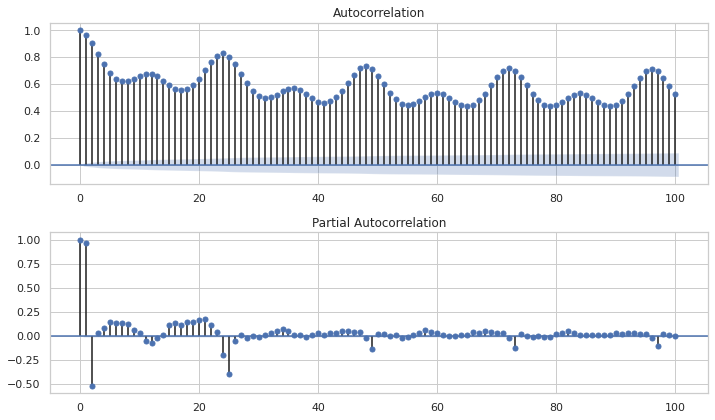

In [ ]:
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(weathergy['price actual'], lags=100, ax=ax1)
plot_pacf(weathergy['price actual'], lags=100, ax=ax2)
plt.tight_layout()
plt.show()

Justify the time lag chosen from the autocorrelation and partial autcorrelation plot. Direct relationship between an observation at a given hour (t) is strongest with the observations at t-1, t-2, t-24

In [ ]:
def twenty_four_hour_split(start_index, end_index, history_size, dataset_target, target) :

  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None :
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index) :
    indices = range(i - history_size, i)
    data.append(dataset_target.iloc[indices])
    labels.append(target[i])

  data_array = np.array(data)
  data_shaped = data_array.reshape(-1, data_array.shape[1] * data_array.shape[2])

  t_feats = []

  for i in list(range(24, 0, -1)) :
    for feat in list(dataset_target.columns) :
      t_feats.append((feat + ' t-%d' % i))

  DATA = pd.DataFrame(data = data_shaped, columns = t_feats)

  return (DATA, labels)

In [ ]:
X, Y = twenty_four_hour_split(start_index = 0, end_index = 35063, history_size = 24, dataset_target = weathergy.drop('time', axis = 1), target = weathergy['price actual'])

In [ ]:
# Train set : 2015 - 2016 - 2017
# Test set : 2018

A_train = X.iloc[:26280]
B_train = Y[:26280]

A_test = X.iloc[26280:]
B_test = Y[26280:]

In [ ]:
all_models = [('LinearRegression()', linregressor), ('RandomForestRegressor()', rfr), ('LGBMRegressor()', lightgbm), ('CatBoostRegressor()', Cat), ('XGBRegressor()', xgb)]

R = []

for (name, model) in all_models :
  model.fit(X = A_train, y = B_train)

  model_predicted_train = model.predict(A_train)
  model_predicted_test = model.predict(A_test)

  model_RMSE_train = np.sqrt(MSE(y_true = B_train , y_pred =  model_predicted_train))
  model_RMSE_test = np.sqrt(MSE(y_true = B_test , y_pred = model_predicted_test))

  R.append((name, round(model_RMSE_train, 3), round(model_RMSE_test, 3)))

MODELS_24h = pd.DataFrame(data = R, columns = ['Models', 'Train_RMSE 24h', 'Test_RMSE 24h'])

In [ ]:
MODELS_24h

,Models,Train_RMSE 24h,Test_RMSE 24h
0,LinearRegression(),2.290,2.293
1,RandomForestRegressor(),0.950,2.488
2,LGBMRegressor(),1.902,2.338
3,CatBoostRegressor(),1.669,2.264
4,XGBRegressor(),2.378,2.415


# 10. WORST AND BEST PREDICTED DAYS

In [ ]:
prediction_lgb = prediction_lgb.reshape(-1,1)

In [ ]:
L = [(a[0],b[0]) for (a,b) in zip(y_test,prediction_lgb)]
df = pd.DataFrame(data=L, columns=['price actual','predicted'])
df

In [ ]:
weathergy_copy = weathergy[26280:]
weathergy_copy['time'] = weathergy_copy.index
weathergy_copy = weathergy_copy.merge(df, on=['price actual'], how ='outer')
weathergy_copy['dayofmonth'] = weathergy_copy['time'].dt.day
weathergy_copy['year'] = weathergy_copy['time'].dt.year

In [ ]:
import numpy as np
weathergy_copy['error'] = weathergy_copy['price actual'] - weathergy_copy['predicted']
weathergy_copy['abs_error'] = weathergy_copy['error'].apply(np.abs)
error_by_day = weathergy_copy.groupby(['year','month','dayofmonth']) \
    .mean()[['price actual','predicted','error','abs_error']]

**The over forcasted days**

In [ ]:
error_by_day.sort_values('error', ascending=True).head(10)

price actual  predicted     error  abs_error
year month dayofmonth                                              
2018 3     11             16.375200  19.008814 -2.633614   2.976342
           30             15.090769  17.673832 -2.583063   2.633085
     1     1              21.200769  22.847211 -1.646442   2.796487
     3     29             37.562424  39.058743 -1.496319   2.588940
     4     29             38.420000  39.329546 -0.909546   2.753194
     1     4              50.396780  51.120365 -0.723585   2.545826
     5     3              50.771458  51.389527 -0.618069   1.640442
     4     2              39.584242  40.127366 -0.543124   1.766242
           19             53.854727  54.397211 -0.542484   1.652016
     1     3              55.384697  55.887780 -0.503083   2.360057

**Worst absolute predicted days**

In [ ]:
error_by_day.sort_values('abs_error', ascending=False).head(10)

price actual  predicted     error  abs_error
year month dayofmonth                                              
2018 3     11             16.375200  19.008814 -2.633614   2.976342
           12             52.289615  50.875162  1.414453   2.896656
     1     1              21.200769  22.847211 -1.646442   2.796487
     4     29             38.420000  39.329546 -0.909546   2.753194
     3     14             50.604340  50.643554 -0.039214   2.678083
           30             15.090769  17.673832 -2.583063   2.633085
     1     2              53.799206  52.758883  1.040323   2.623482
     3     29             37.562424  39.058743 -1.496319   2.588940
     1     4              50.396780  51.120365 -0.723585   2.545826
     3     31             31.038462  30.865289  0.173173   2.496353

**Best predicted days**

In [ ]:
error_by_day.sort_values('abs_error', ascending=True).head(10)

price actual  predicted     error  abs_error
year month dayofmonth                                              
2018 7     25             71.251919  70.582889  0.669030   1.191527
     8     23             72.162323  71.788670  0.373653   1.268821
     11    15             69.278953  68.752695  0.526258   1.321551
     12    5              68.630854  68.534920  0.095934   1.323958
     11    23             71.710874  71.188620  0.522253   1.333581
     5     2              53.549636  53.331548  0.218088   1.335268
     11    16             69.735747  69.630856  0.104891   1.338407
     5     5              52.365362  51.999633  0.365729   1.339584
           15             58.527368  58.397741  0.129627   1.343682
     9     19             79.603103  78.893747  0.709356   1.354359